In [1]:
import hist
import dask
import awkward as ak
import hist.dask as hda
import numpy as np
from hist import Hist, axis, storage, loc

from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector as vec
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
from coffea.lumi_tools import LumiMask
from coffea.nanoevents import NanoAODSchema

GOLDEN_JSON = "/home/cms-jovyan/21_09_25_data_MC/25_1_26/Golden_data.json"
            
def trigger_nEle_selection(events):
    # apply trigger selection, number of electrons
    trigger_nelectron = (events.HLT_Ele30_WPTight_Gsf| events.HLT_Photon200) & (events.nElectron >= 2) 
    events = events[trigger_nelectron]
    electrons = ak.zip(
        {
            "pt": events.Electron_pt,
            "eta": events.Electron_eta,
            "phi": events.Electron_phi,
            "mass": events.Electron_mass,
            "charge": events.Electron_charge,
            "dz": events.Electron_dz,
            "mvaNoIso_WP80": events.Electron_mvaNoIso_WP80,
            "mvaNoIso_WP90": events.Electron_mvaNoIso_WP90,
            "mvaIso_WP80": events.Electron_mvaIso_WP80,
            "nElectron": events.nElectron,
            "superclusterEta": events.Electron_superclusterEta,
            "idx": ak.local_index(events.Electron_pt, axis=1),
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )
    return events, electrons
    
def apply_mva(electrons):
    # apply mva cut
    cut_mva = (electrons.mvaNoIso_WP90 > 0) 
    return electrons[cut_mva]
    
def veto_ecal_trans_region(ele2):
    #veto ECAL transition region: 1.44 < |η| < 1.57
    abs_sc_eta = np.abs(ele2.superclusterEta)
    eta_transition_cut = (abs_sc_eta > 1.44) & (abs_sc_eta < 1.57)
    return ele2[~eta_transition_cut]

def select_tag(events, ele2):
    #select tag
    # pt > 35 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
    # barrel ( |eta supercluster| <= 1.479)
    # endcap ( |eta supercluster| > 1.479)
    # Tight MVA ID: Electron.mvaIso_WP80 > 0
    is_barrel = (np.abs(ele2.superclusterEta) <= 1.479)
    is_endcap = (np.abs(ele2.superclusterEta) > 1.479) 
    dz_tag_cut  = ak.where(is_barrel, ele2.dz < 0.10, ele2.dz < 0.20)
    pt_tag_cut  = (ele2.pt > 35)
    abs_superclusterEta_tag_cut= (np.abs(ele2.superclusterEta) < 2.5)
    tight_mva_cut = (ele2.mvaIso_WP80 > 0) 
    tag_cut = pt_tag_cut & abs_superclusterEta_tag_cut & dz_tag_cut & tight_mva_cut
    
    e_tag = ele2[tag_cut]
    not_tag_e_tagcut = ele2[~tag_cut] 

    #clean up all lists: only events with at least one tag electron remain
    has_tag = ak.num(e_tag) > 0
    return events[has_tag],ele2[has_tag], e_tag[has_tag],not_tag_e_tagcut[has_tag]
    
def build_trig_electrons(events):
    trig_e = ak.zip(
        {
            "pt": events.TrigObj_pt,
            "eta": events.TrigObj_eta,
            "phi": events.TrigObj_phi,
            "mass": ak.zeros_like(events.TrigObj_pt),
            "id": events.TrigObj_id,
            "filterBits": events.TrigObj_filterBits,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )
    a = (trig_e.id == 11)
    b = (trig_e.filterBits & (1 << 12)) != 0
    c = (trig_e.filterBits & (1 << 14)) != 0
    trig_obj_cut= a & (b | c)
    return trig_e[trig_obj_cut]
    
def match_trigger_obj(events, ele2, e_tag, not_tag_e_tagcut):
    #check if the electron and trigger obj dR matches (if more than 1 tagged e find the one that matches with the trigger obj)
    trig_electrons = build_trig_electrons(events)
    pairs_e_trigObj = ak.cartesian(
        {"e_info": e_tag, "trig_obj": trig_electrons}, axis=1, nested=True
    )
    dR = pairs_e_trigObj.e_info.delta_r(pairs_e_trigObj.trig_obj)
    match_cut = ak.any(dR < 0.1, axis=2)
    e_tag_matched = e_tag[match_cut]
    
    #clean up lists
    keep_evt = ak.num(e_tag_matched) > 0
    ntags_per_event_before = ak.num(e_tag_matched[keep_evt], axis=1)
    return events[keep_evt], e_tag_matched[keep_evt], ele2[keep_evt], e_tag[keep_evt],not_tag_e_tagcut[keep_evt],ntags_per_event_before

def get_probe(probe_cand):
    # get probe e: pt > 10 GeV AND ak.abs(eta) < 2.5
    probe_cut = (probe_cand.pt > 10) & (np.abs(probe_cand.superclusterEta) < 2.5)
    probe = probe_cand[probe_cut]
    return probe

def pair_mass_check(e_tag_matched, probe):
    # build the tag-probe pair and test which is within the z mass window
    tp_pairs = ak.cartesian({"tag": e_tag_matched, "probe": probe}, axis=1, nested=True)
    p_mu_tot = tp_pairs.tag + tp_pairs.probe
    mass_constructed = p_mu_tot.mass
    z_win = (mass_constructed > 70.0) & (mass_constructed < 110.0)
    good_pairs = tp_pairs[z_win]
    mass_all = ak.to_numpy(ak.flatten(mass_constructed, axis=None)) #for check
    mass_good = ak.to_numpy(ak.flatten(mass_constructed[z_win], axis=None)) #for check
    n_probes_after  = ak.num(ak.flatten(good_pairs.tag, axis=2), axis=1) #for check
    probes_per_tag_after = ak.num(good_pairs.tag, axis=2) #for check
    n_tags_after = ak.sum(probes_per_tag_after > 0, axis=1) #for check
    #the pairs are ready
    return good_pairs, mass_all, mass_good, n_probes_after, probes_per_tag_after, n_tags_after

In [2]:
# start actual processing
class MyProcessor(processor.ProcessorABC):
    def __init__(self, golden_json=None, norm_weights=None):
        self._mask = LumiMask(golden_json) if golden_json else None
        self._norm_w = norm_weights or {}

    def process(self, events):
        dataset = events.metadata['dataset']
        is_data = (dataset == "data")
        all_e_pt = events.Electron_pt   # for check
        all_e_superclusterEta = events.Electron_superclusterEta   # for check
        
        #######################################
        #DATA-only lumi mask bookkeeping
        n0 = len(events.event)
        if is_data and (self._mask is not None):
            good = self._mask(events.run, events.luminosityBlock)
            n_keep = ak.count_nonzero(good)
            events = events[good]
        else:
            n_keep = ak.count_nonzero(ak.ones_like(events.event, dtype=bool))
            
        events, electrons = trigger_nEle_selection(events)
        ele2 = apply_mva(electrons)
        ele2_check = ele2  # for check
        
        ele2=veto_ecal_trans_region(ele2)
        ele2_after_eta_transition_cut_check = ele2  # for check
        
        events, ele2, e_tag, not_tag_e_tagcut = select_tag(events, ele2)
        e_tag_check = e_tag  # for check
        not_tag_e_tagcut_check = not_tag_e_tagcut  # for check

        events, e_tag_matched, ele2, e_tag, probe_cand, ntags_per_event_before = match_trigger_obj(events, ele2, e_tag, not_tag_e_tagcut)
        e_tag_matched_check = e_tag_matched  # for check
        probe_cand_check = probe_cand  # for check
        
        probe = get_probe(probe_cand)
        probe_check = probe  # for check
        
        good_pairs, mass_all, mass_good, n_probes_after, probes_per_tag_after, n_tags_after = pair_mass_check(e_tag_matched, probe)

        
        #get different situations of charge
        q_tag   = good_pairs.tag.charge
        q_probe = good_pairs.probe.charge    
        tag=good_pairs.tag
        probe=good_pairs.probe

        tag_idx   = tag.idx #check tag probe no overlap
        probe_idx = probe.idx #check tag probe no overlap
        same = (tag_idx == probe_idx) #check tag probe no overlap
        n_same = ak.sum(same) #check tag probe no overlap

        ########################################################
        # make histogram
        tag_pt   = ak.to_numpy(ak.flatten(tag.pt,   axis=None))
        probe_pt = ak.to_numpy(ak.flatten(probe.pt, axis=None))
        
        tag_eta   = ak.to_numpy(ak.flatten(tag.superclusterEta,   axis=None))
        probe_eta = ak.to_numpy(ak.flatten(probe.superclusterEta, axis=None))
        
        q_tag   = ak.to_numpy(ak.flatten(tag.charge,   axis=None))
        q_probe = ak.to_numpy(ak.flatten(probe.charge, axis=None))
        
        w_norm = 1.0 if is_data else float(self._norm_w.get(dataset, 1.0))

        # check mass distribution plot
        ax_mass = axis.Regular(100, 30.0, 150.0, name="mll", label="$m_{ee}$ [GeV]")
        h_mll_all  = Hist(ax_mass, storage=storage.Weight())
        h_mll_good = Hist(ax_mass, storage=storage.Weight())
        w_all  = np.full_like(mass_all,  w_norm, dtype=float)
        w_good = np.full_like(mass_good, w_norm, dtype=float)
        h_mll_all.fill(mll=mass_all,  weight=w_all)
        h_mll_good.fill(mll=mass_good, weight=w_good)


        bins = np.array(list(np.linspace(0, 200, num=11)) + list(np.linspace(240, 400, num=5)) +list(np.linspace(500, 2000, num=16)))

        #tag_ax_pt   = axis.Regular(100, 0, 2000, name="tag_pt",  label="tag $p_T$ [GeV]")
        probe_ax_pt   = axis.Variable(bins, name="probe_pt",  label="Probe $p_T$ [GeV]")
        #tag_ax_eta  = axis.Regular(100, -3, 3,   name="tag_eta", label="tag $\\eta$")
        probe_ax_eta  = axis.Regular(50, -3, 3,   name="probe_eta", label="Probe $\\eta$")
        tag_ax_q = axis.IntCategory([-1, 1], name="tag_q")
        probe_ax_q = axis.IntCategory([-1, 1], name="probe_q")
        probe_ax_reg = axis.IntCategory([0, 1], name="probe_is_barrel") 
        tag_ax_reg = axis.IntCategory([0, 1], name="tag_is_barrel")
        #ax_pair_charge   = axis.StrCategory(["pp", "mm","pm"], name="pair_charge")
        ax_tag_ptbin  = axis.StrCategory(["35to100", "lt100"], name="tag_ptbin")

        
        h_pairs = Hist(
                        probe_ax_pt, probe_ax_eta,
                        tag_ax_q, probe_ax_q, probe_ax_reg, 
                        ax_tag_ptbin, 
                        tag_ax_reg, storage=storage.Weight()
                        )


        q_tag_int   = q_tag.astype(int)
        q_probe_int = q_probe.astype(int)           
        probe_is_barrel = (np.abs(probe_eta) <= 1.479).astype(int)
        tag_is_barrel = (np.abs(tag_eta) <= 1.479).astype(int)
        tag_ptbin = np.where((tag_pt >= 35) & (tag_pt <= 100), "35to100", "lt100")
        
        h_pairs.fill(
                    probe_pt=probe_pt,
                    probe_eta=probe_eta,
                    tag_q=q_tag_int,
                    probe_q=q_probe_int,
                    probe_is_barrel=probe_is_barrel,
                    tag_ptbin=tag_ptbin,
                    tag_is_barrel=tag_is_barrel,
                    weight=w_norm,
                )
        

        #pT and eta of tag and probe
        h_tag_pt    = Hist(axis.Variable(bins, name="pt"),  storage=storage.Weight())
        h_probe_pt  = Hist(axis.Variable(bins, name="pt"),  storage=storage.Weight())
        h_tag_eta   = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())
        h_probe_eta = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())

        h_tag_pt.fill(pt=tag_pt,       weight=w_norm)
        h_probe_pt.fill(pt=probe_pt,   weight=w_norm)
        h_tag_eta.fill(eta=tag_eta,    weight=w_norm)
        h_probe_eta.fill(eta=probe_eta, weight=w_norm)


        tag_ax_pt   = axis.Variable(bins, name="tag_pt",  label="tag $p_T$ [GeV]")
        probe_ax_pt   = axis.Variable(bins, name="probe_pt",  label="Probe $p_T$ [GeV]")
        probe_ax_eta  = axis.Regular(50, -3, 3,   name="probe_eta", label="Probe $\\eta$")
        tag_ax_eta  = axis.Regular(50, -3, 3,   name="tag_eta", label="Tag $\\eta$")
        

        ######################################
        #for check hist
        ax_pt  = axis.Regular(100, 0, 2000, name="pt")
        ax_eta = axis.Regular(100, -3, 3,   name="eta")
        
        def make_pt_eta_hists():
            return (
                Hist(ax_pt,  storage=storage.Weight()),
                Hist(ax_eta, storage=storage.Weight())
            )

        def fill_pt_eta(h_pt: Hist, h_eta: Hist, pts, etas, w_val):
            pts_flat  = ak.to_numpy(ak.flatten(pts, axis=None))
            etas_flat = ak.to_numpy(ak.flatten(etas, axis=None))
            w_arr_pt  = np.full_like(pts_flat,  w_val, dtype=float)
            h_pt.fill(pt=pts_flat, weight=w_arr_pt)
            w_arr_eta = np.full_like(etas_flat, w_val, dtype=float)
            h_eta.fill(eta=etas_flat, weight=w_arr_eta)


        h_event_check_pt, h_event_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_event_check_pt, h_event_check_eta, all_e_pt, all_e_superclusterEta, w_norm)
        
        h_ele2_check_pt, h_ele2_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_ele2_check_pt, h_ele2_check_eta, ele2_check.pt, ele2_check.superclusterEta, w_norm)

        h_e_tag_check_pt, h_e_tag_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_e_tag_check_pt, h_e_tag_check_eta, e_tag_check.pt, e_tag_check.superclusterEta, w_norm)

        h_not_tag_e_tagcut_check_pt, h_not_tag_e_tagcut_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_not_tag_e_tagcut_check_pt, h_not_tag_e_tagcut_check_eta, not_tag_e_tagcut_check.pt, not_tag_e_tagcut_check.superclusterEta, w_norm)

        h_e_tag_matched_check_pt, h_e_tag_matched_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_e_tag_matched_check_pt, h_e_tag_matched_check_eta, e_tag_matched_check.pt, e_tag_matched_check.superclusterEta, w_norm)

        h_probe_cand_check_pt, h_probe_cand_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_probe_cand_check_pt, h_probe_cand_check_eta, probe_cand_check.pt, probe_cand_check.superclusterEta, w_norm)

        h_probe_check_pt, h_probe_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_probe_check_pt, h_probe_check_eta, probe_check.pt, probe_check.superclusterEta, w_norm)

        h_ele2_after_eta_transition_cut_check_pt, h_ele2_after_eta_transition_cut_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_ele2_after_eta_transition_cut_check_pt, h_ele2_after_eta_transition_cut_check_eta, ele2_after_eta_transition_cut_check.pt, ele2_after_eta_transition_cut_check.superclusterEta, w_norm)
        #######################################################################################################

        return {
            dataset: {   
                #------------check---------------------
                "h_event_check_pt": [h_event_check_pt], 
                "h_event_check_eta": [h_event_check_eta],
                "h_ele2_check_pt": [h_ele2_check_pt], 
                "h_ele2_check_eta": [h_ele2_check_eta],
                "h_e_tag_check_pt": [h_e_tag_check_pt], 
                "h_e_tag_check_eta": [h_e_tag_check_eta],
                "h_not_tag_e_tagcut_check_pt": [h_not_tag_e_tagcut_check_pt], 
                "h_not_tag_e_tagcut_check_eta": [h_not_tag_e_tagcut_check_eta],
                "h_e_tag_matched_check_pt": [h_e_tag_matched_check_pt], 
                "h_e_tag_matched_check_eta": [h_e_tag_matched_check_eta],
                "h_probe_cand_check_pt": [h_probe_cand_check_pt], 
                "h_probe_cand_check_eta": [h_probe_cand_check_eta],
                "h_probe_check_pt": [h_probe_check_pt], 
                "h_probe_check_eta": [h_probe_check_eta],
                "h_ele2_after_eta_transition_cut_check_pt": [h_ele2_after_eta_transition_cut_check_pt], 
                "h_ele2_after_eta_transition_cut_check_eta": [h_ele2_after_eta_transition_cut_check_eta],
                "n0": [n0],             
                "n_keep": [n_keep],
                "h_mll_all": [h_mll_all],
                "h_mll_good": [h_mll_good],
                "n_same_tag_probe": [n_same],
                "h_tag_pt" : [h_tag_pt],   
                "h_probe_pt" : [h_probe_pt], 
                "h_tag_eta" : [h_tag_eta], 
                "h_probe_eta" : [h_probe_eta],
                "ntags_per_event_before": [ntags_per_event_before],
                "n_probes_after":  [n_probes_after],
                "n_tags_after": [n_tags_after],
                
                #-------------main output
                "h_pairs" : [h_pairs],                   
            }
    }

    def postprocess(self, accumulator):
        def sum_int_list(lst):
            return int(np.sum(lst))
    
        def merge_hist_list(val):
            if not isinstance(val, list):
                val = [val]
            h = val[0].copy()
            for hi in val[1:]:
                h += hi
            return h



        scalar_keys = ["n0", "n_keep", "n_same_tag_probe"]
        hist_keys = [
            "h_tag_pt", "h_probe_pt", "h_tag_eta", "h_probe_eta",
            "h_pairs",
            "h_event_check_pt", "h_event_check_eta",
            "h_ele2_check_pt", "h_ele2_check_eta",
            "h_e_tag_check_pt", "h_e_tag_check_eta",
            "h_not_tag_e_tagcut_check_pt", "h_not_tag_e_tagcut_check_eta",
            "h_e_tag_matched_check_pt", "h_e_tag_matched_check_eta",
            "h_probe_cand_check_pt", "h_probe_cand_check_eta",
            "h_probe_check_pt", "h_probe_check_eta",
            "h_ele2_after_eta_transition_cut_check_pt", "h_ele2_after_eta_transition_cut_check_eta",
            "h_mll_all", "h_mll_good"

        ]
    
        out = {}
    
        for ds, d in accumulator.items():
            ds_out = {}
            for k in scalar_keys:
                if k in d:
                    ds_out[k] = sum_int_list(d[k])
    
            for k in hist_keys:
                if k in d:
                    merged = merge_hist_list(d[k])
                    if merged is not None:
                        ds_out[k] = merged
    
            out[ds] = ds_out

        return out


In [ ]:
#calculate normalizing weights for MC
#for # of events, calculating chunck by chunck to avoid timming error
import numpy as np
import uproot

def runs_count(files):
    total = 0
    for fp in files:
        with uproot.open(fp) as f:
            runs = f["Runs"]
            total += runs["genEventCount"].array(library="np").sum()
    return int(total)
    
def run_part(files, part_idx, part_size=200):
    n_files = len(files)
    i0 = part_idx * part_size
    i1 = min((part_idx + 1) * part_size, n_files)
    n = runs_count(files[i0:i1])
    print("n =", n)
    return n



In [ ]:
# count # of events
import json
with open("/home/cms-jovyan/21_09_25_data_MC/25_1_26/DY_MC.json") as f:
    bins_to_files = json.load(f)

files_0J = bins_to_files["DY_Bin-0J"]
files_1J = bins_to_files["DY_Bin-1J"]
files_2J = bins_to_files["DY_Bin-2J"]
n_0J_0 = run_part(files_0J, part_idx=0, part_size=100)
n_0J_0 = run_part(files_0J, part_idx=0, part_size=100)
n_0J_1 = run_part(files_0J, part_idx=1, part_size=100)
n_0J_2 = run_part(files_0J, part_idx=2, part_size=100)
n_0J_3 = run_part(files_0J, part_idx=3, part_size=100)
n_0J_4 = run_part(files_0J, part_idx=4, part_size=100)
n_0J_5 = run_part(files_0J, part_idx=5, part_size=100)
n_1J_0 = run_part(files_1J, part_idx=0, part_size=100)
n_1J_1 = run_part(files_1J, part_idx=1, part_size=100)
n_1J_2 = run_part(files_1J, part_idx=2, part_size=100)
n_1J_3 = run_part(files_1J, part_idx=3, part_size=100)
n_1J_4 = run_part(files_1J, part_idx=4, part_size=100)
n_1J_5 = run_part(files_1J, part_idx=5, part_size=100)
n_1J_6 = run_part(files_1J, part_idx=6, part_size=100)
n_1J_7 = run_part(files_1J, part_idx=7, part_size=100)
n_1J_8 = run_part(files_1J, part_idx=8, part_size=100)
n_1J_9 = run_part(files_1J, part_idx=9, part_size=100)
n_1J_10 = run_part(files_1J, part_idx=10, part_size=100)
n_1J_11 = run_part(files_1J, part_idx=11, part_size=100)
n_1J_12 = run_part(files_1J, part_idx=12, part_size=100)
n_1J_13 = run_part(files_1J, part_idx=13, part_size=100)
n_1J_14 = run_part(files_1J, part_idx=14, part_size=100)
n_1J_15 = run_part(files_1J, part_idx=15, part_size=100)
n_1J_16 = run_part(files_1J, part_idx=16, part_size=100)
n_1J_17 = run_part(files_1J, part_idx=17, part_size=100)
n_1J_18 = run_part(files_1J, part_idx=18, part_size=100)
n_1J_19 = run_part(files_1J, part_idx=19, part_size=100)
n_1J_20 = run_part(files_1J, part_idx=20, part_size=100)
n_1J_21 = run_part(files_1J, part_idx=21, part_size=100)
n_2J_0 = run_part(files_2J, part_idx=0, part_size=100)
n_2J_1 = run_part(files_2J, part_idx=1, part_size=100)
n_2J_2 = run_part(files_2J, part_idx=2, part_size=100)
n_2J_3 = run_part(files_2J, part_idx=3, part_size=100)

In [ ]:
n_0J  = n_0J_0 + n_0J_1 + n_0J_2 + n_0J_3 + n_0J_4 + n_0J_5  
n_1J = n_1J_0 + n_1J_1 + n_1J_2 + n_1J_3 + n_1J_4 + n_1J_5 + n_1J_6 + n_1J_7 + n_1J_8 + n_1J_9 + n_1J_10 + n_1J_11 + n_1J_12 + n_1J_13 + n_1J_14 + n_1J_15 + n_1J_16 + n_1J_17 + n_1J_18 + n_1J_19 + n_1J_20 + n_1J_21 
n_2J = n_2J_0 + n_2J_1 + n_2J_2 + n_2J_3
print ("n_0J", n_0J)
print ("n_1J", n_1J)
print ("n_2J", n_2J)

In [3]:
xsec_0J = 5382
xsec_1J = 972.3
xsec_2J = 372.4

n_0J=452148458
n_1J=338718394
n_2J=306036146

Lumi = 109.08 * 1000.0

W_0J = (xsec_0J * Lumi) / n_0J
W_1J = (xsec_1J * Lumi) / n_1J
W_2J = (xsec_2J * Lumi) / n_2J
print(W_0J)
print(W_1J)
print(W_2J)


#results:
#W_0J = 1.298397793054068
#W_1J = 0.3131169900386337
#W_2J = 0.13273396796730016


W = {
    "DY_Bin-0J":  W_0J,
    "DY_Bin-1J": W_1J,
    "DY_Bin-2J": W_2J,
}


1.298397793054068
0.3131169900386337
0.13273396796730016


In [ ]:
# loop over files with issue again at the end
import json, numpy as np, uproot

with open("/home/cms-jovyan/21_09_25_data_MC/25_1_26/DY_MC.json") as f:
    bins_to_files = json.load(f)
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
from dask.distributed import Client
from coffea.util import save, load
client = Client("tls://192.168.161.154:8786")

CHUNK_SIZE = 10

def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def run_file(fileset_chunk):
    runner = processor.Runner(
            executor=processor.DaskExecutor(client=client, compression=None, treereduction=5, retries=1),
            schema=BaseSchema,
            skipbadfiles=True,         
            xrootdtimeout=60,
        )

    proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)
    out = runner(fileset_chunk, processor_instance=proc)
    
    save(out, f"/home/cms-jovyan/21_09_25_data_MC/25_1_26/test_mc{i}.coffea")
    print(f"[{i}] {ds_name} chunk {j} : {len(files_chunk)} files -> test_mc{i}.coffea")

bins_map = {
    #"DY_Bin-0J": "DY_Bin-0J",
    # "DY_Bin-1J": "DY_Bin-1J",
     "DY_Bin-2J": "DY_Bin-2J",
}

i = 0

bad_list = []

for ds_name, bin_key in bins_map.items():
    files = bins_to_files[bin_key]
    for j, files_chunk in enumerate(chunk_list(files, CHUNK_SIZE)):
        fileset_chunk = {
            ds_name: {"files": {fp: "Events" for fp in files_chunk}}
        }

        try:
            run_file(fileset_chunk)
        except ValueError as e:
            print("bad file! " + str(i))
            bad_list.append((i, fileset_chunk))
        i += 1

print(bad_list)
new_bad_list = []

while (len(bad_list) > 0):
    for (new_i, chunk) in bad_list:
        try:
            i = new_i
            run_file(chunk)
        except ValueError as e:
            print("File is bad again! " + str(i))
            new_bad_list.append((i,chunk))
    bad_list = new_bad_list
    new_bad_list = []

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
from dask.distributed import Client
from coffea.util import save, load
client = Client("tls://192.168.161.144:8786")

for file_idx in range(1, 12): 
    json_name = f"/home/cms-jovyan/21_09_25_data_MC/25_1_26/data_files_{file_idx}.json"
    with open(json_name) as f:
        data_files = json.load(f)

    all_paths  = list(data_files.keys())
    chunk_size = 10

    for i_start in range(0, len(all_paths), chunk_size):
        paths = all_paths[i_start : i_start + chunk_size]  

        data_files_i = {p: data_files[p] for p in paths}

        part_idx = i_start // chunk_size 

        fileset_i = {
            "data": {
                "files": data_files_i,
            }
        }

        runner = processor.Runner(
            executor=processor.DaskExecutor(client=client, compression=None, treereduction=5, retries=1),
            schema=BaseSchema,
            skipbadfiles=True,         
            xrootdtimeout=60,
        )
        
        proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)
        
        proc_out = runner(fileset_i, processor_instance=proc)

        save(proc_out, f"/home/cms-jovyan/21_09_25_data_MC/25_1_26/output_{file_idx}_{part_idx}.coffea")
        print(f"output_{file_idx}_{part_idx}.coffea")

In [8]:
from coffea.util import load
from coffea import processor

mc_accs = []

for i in range (0, 299):
    mc_accs.append(load(f"/home/cms-jovyan/21_09_25_data_MC/25_1_26/output_mc{i}.coffea") )

n_chunks = [72,41,43,53,54,45,51,49,63,49,58]
data_accs = []
for j in range(1, 12):
    for i in range(0, n_chunks[j-1]):
        data_accs.append(load(f"/home/cms-jovyan/21_09_25_data_MC/25_1_26/output_{j}_{i}.coffea"))
    
combined_data = processor.accumulate(mc_accs + data_accs)


proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)
out = proc.postprocess(combined_data)

ds_data  = out["data"]
ds_mc_Bin_0J = out["DY_Bin-0J"]
ds_mc_Bin_1J = out["DY_Bin-1J"]
ds_mc_Bin_2J = out["DY_Bin-2J"]

<>:101: SyntaxWarning: invalid escape sequence '\e'
<>:101: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_23995/3789734675.py:101: SyntaxWarning: invalid escape sequence '\e'
  title=f"{nice}: $\eta$ (Data vs MC)",


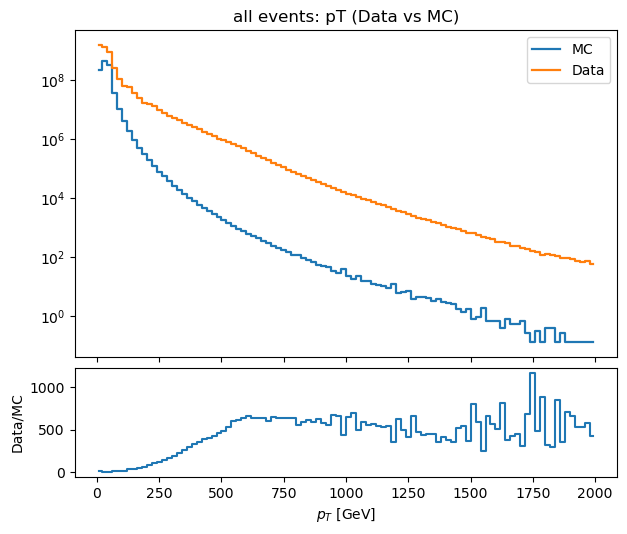

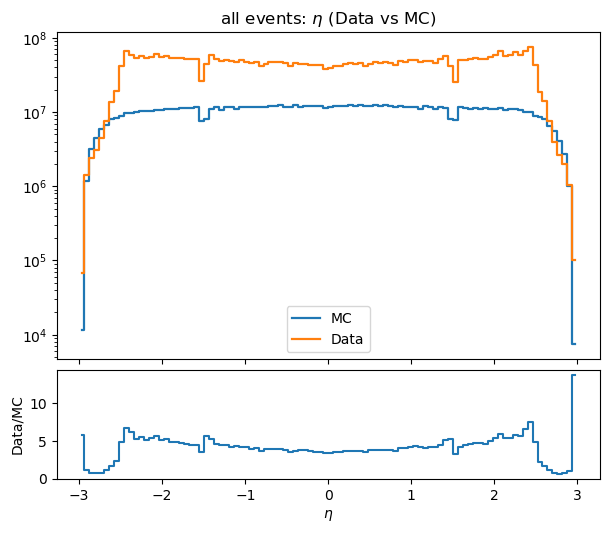

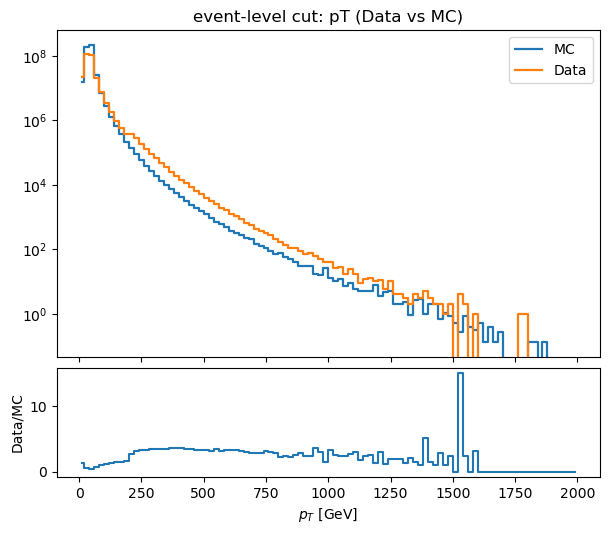

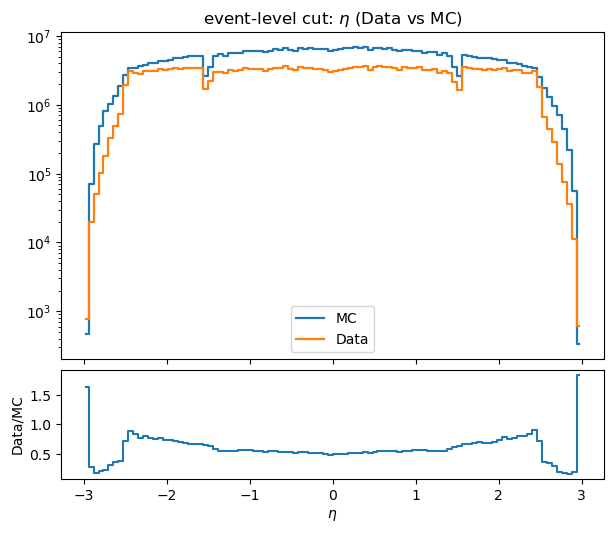

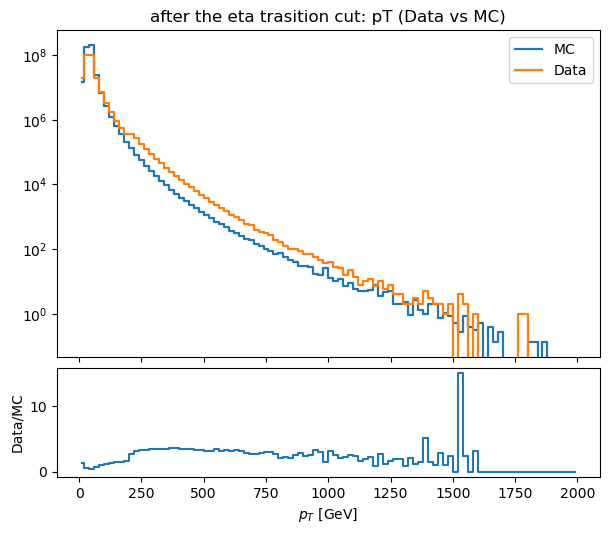

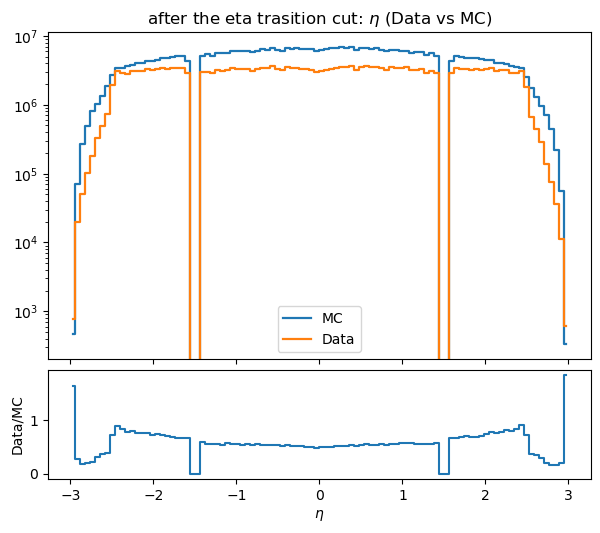

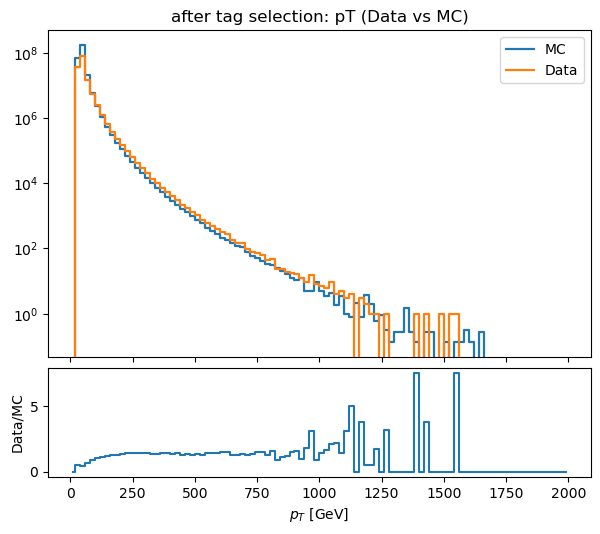

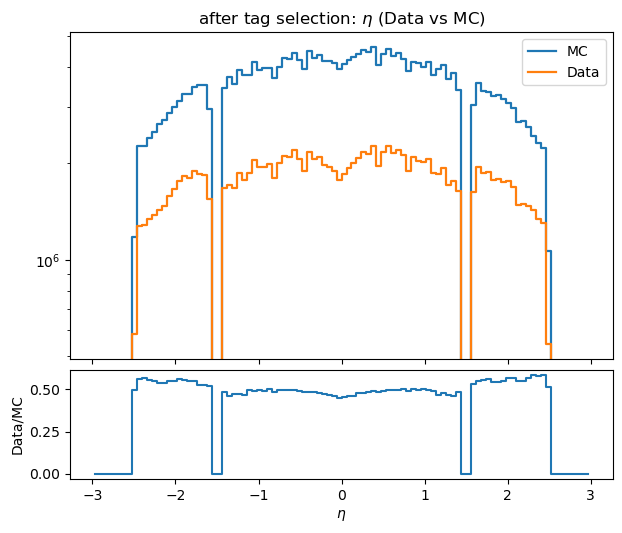

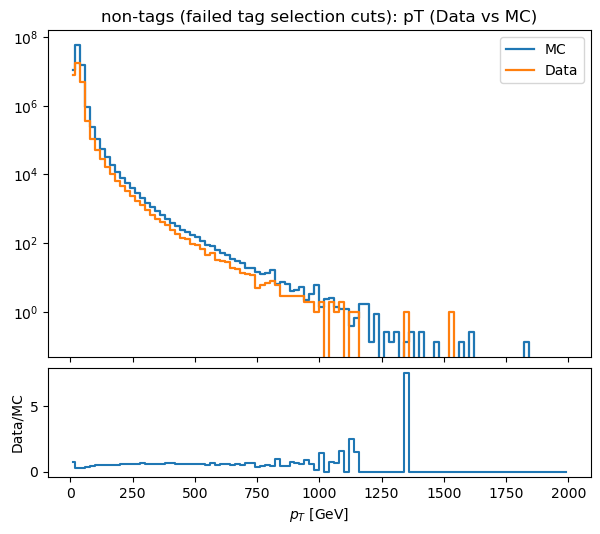

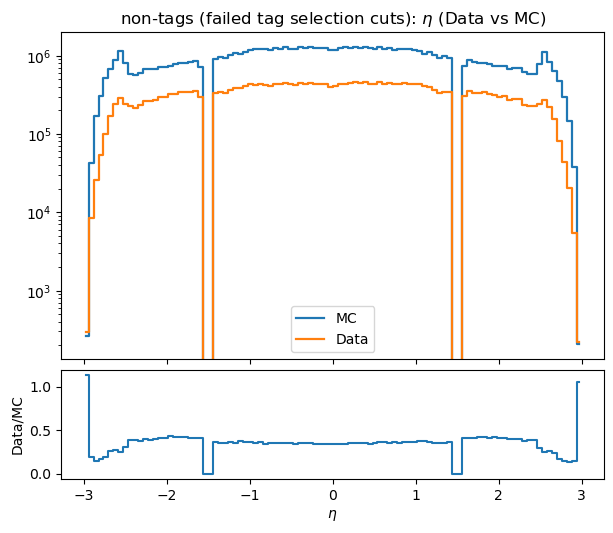

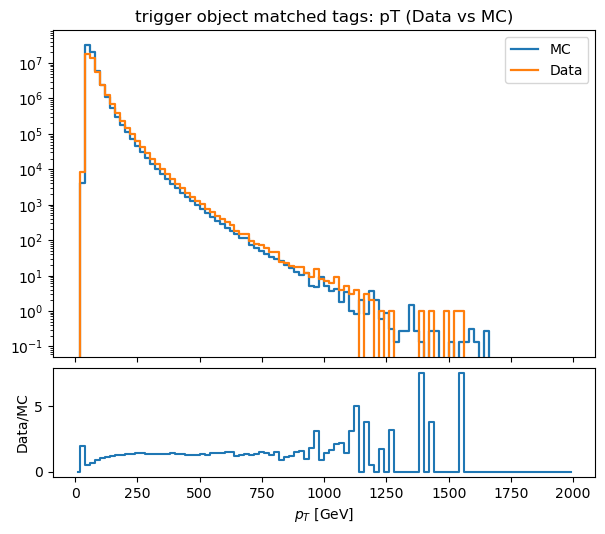

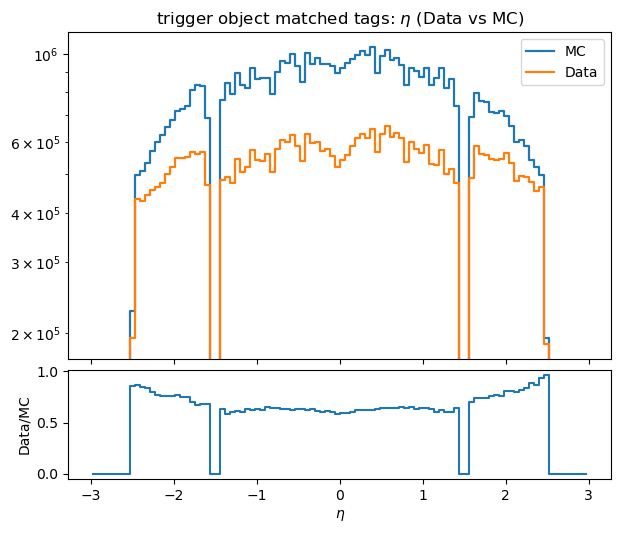

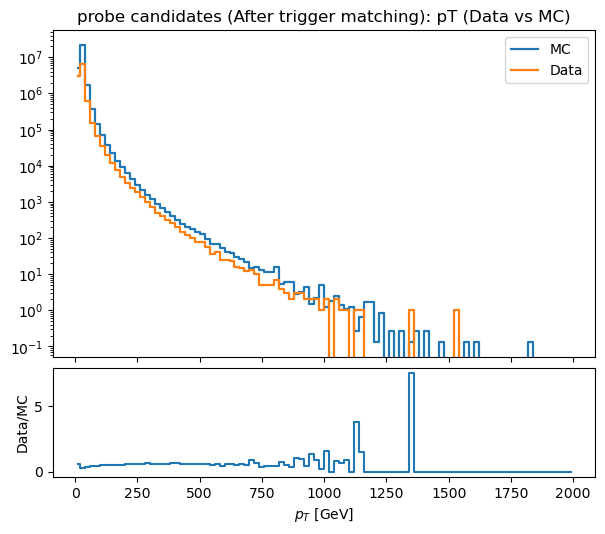

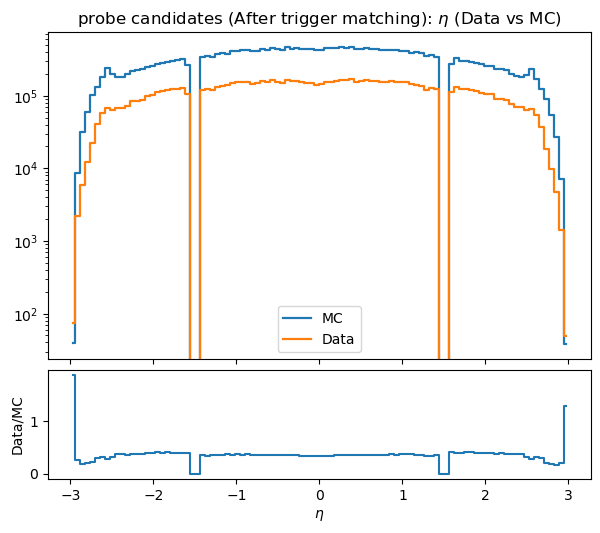

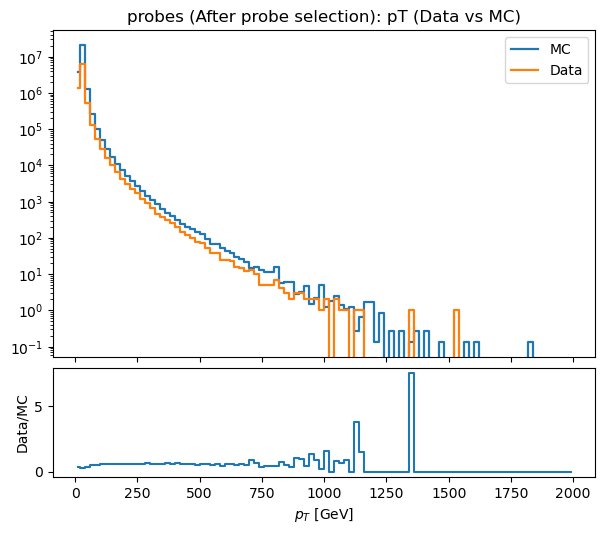

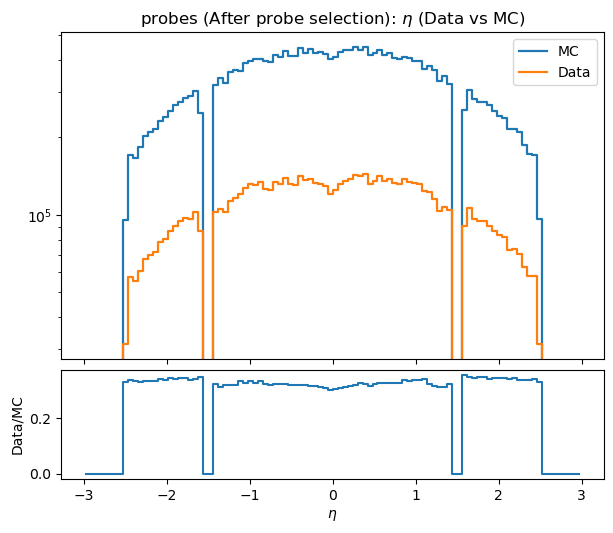

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def add_hists(*hs: Hist) -> Hist:
    h = hs[0].copy()
    for x in hs[1:]:
        h += x
    return h

def mc_sum(key):
    return add_hists(ds_mc_Bin_0J[key], ds_mc_Bin_1J[key],
                     ds_mc_Bin_2J[key])

def dt_get(key):
    return ds_data[key]

def plot_data_mc_with_ratio(h_data: Hist, h_mc: Hist, xlabel: str, title: str, ylim=None, logy=False, ylabel=None, density=False, pt_plot=False):
    centers = h_mc.axes[0].centers
    d_vals  = h_data.values()
    m_vals  = h_mc.values()
    edges   = h_mc.axes[0].edges
    widths  = np.diff(edges)


    fig = plt.figure(figsize=(7, 5.8))
    gs  = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
    ax  = fig.add_subplot(gs[0])
    rax = fig.add_subplot(gs[1], sharex=ax)

    if pt_plot==True:
        m_vals = m_vals / widths
        d_vals = d_vals / widths

    if density:
        m_area = np.sum(m_vals * widths)
        d_area = np.sum(d_vals * widths)
        m_vals = m_vals / m_area  
        d_vals = d_vals / d_area

    ratio = np.divide(d_vals, m_vals, out=np.zeros_like(d_vals, dtype=float), where=m_vals>0)
    ax.step(centers, m_vals, where="mid", linewidth=1.6, label="MC")
    ax.step(centers, d_vals, where="mid", linewidth=1.6, label="Data")

    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    if logy==True:
        ax.set_yscale("log")
    if ylabel==None:
        ax.set_ylabel("Events")
        if pt_plot==True:
            ax.set_ylabel("Events / GeV")
            if density==True:
                ax.set_ylabel("1 / GeV")
    else:
        ax.set_ylabel(ylabel)
        
    ax.set_title(title)
    ax.legend()

    rax.step(centers, ratio, where="mid")
    rax.set_ylabel("Data/MC")
    rax.set_xlabel(xlabel)

    plt.setp(ax.get_xticklabels(), visible=False)
    #plt.tight_layout()
    plt.show()



stages = {
    "event_check": ("h_event_check_pt", "h_event_check_eta", "all events"),
    "ele2_check": ("h_ele2_check_pt", "h_ele2_check_eta", "event-level cut"),
    "ele2_after_eta_transition_cut_check": ("h_ele2_after_eta_transition_cut_check_pt","h_ele2_after_eta_transition_cut_check_eta","after the eta trasition cut"),
    "e_tag_check": ("h_e_tag_check_pt", "h_e_tag_check_eta", "after tag selection"),
    "not_tag_e_tagcut_check": ("h_not_tag_e_tagcut_check_pt", "h_not_tag_e_tagcut_check_eta", "non-tags (failed tag selection cuts)"),
    "e_tag_matched_check": ("h_e_tag_matched_check_pt", "h_e_tag_matched_check_eta", "trigger object matched tags"),
    "probe_cand_check": ("h_probe_cand_check_pt", "h_probe_cand_check_eta", "probe candidates (After trigger matching)"),
    "probe_check": ("h_probe_check_pt", "h_probe_check_eta", "probes (After probe selection)"),
}

for stg, (kpt, keta, nice) in stages.items():
    h_mc_pt  = mc_sum(kpt)
    h_dt_pt  = dt_get(kpt)
    h_mc_eta = mc_sum(keta)
    h_dt_eta = dt_get(keta)

    plot_data_mc_with_ratio(
        h_dt_pt, h_mc_pt,
        xlabel=r"$p_T$ [GeV]",
        title=f"{nice}: pT (Data vs MC)",
        ylim=None,
        logy=True,
        ylabel= "",
        #density=True,
        
    )

    plot_data_mc_with_ratio(
        h_dt_eta, h_mc_eta,
        xlabel=r"$\eta$",
        title=f"{nice}: $\eta$ (Data vs MC)",
        ylim=None,
        logy=True,
        ylabel= "",
        #density=True
    )
    

def mc_sum_scalar(key):
    return (
        ds_mc_Bin_0J[key]
        + ds_mc_Bin_1J[key]
        + ds_mc_Bin_2J[key]
    )





1st plot:
After event level cut: apply trigger selection: events.HLT_Ele30_WPTight_Gsf| events.HLT_Photon200
electrons.mvaNoIso_WP90 > 0 AND nElectron >= 2
ele2_check 

2nd plot:
After the transition religion cut
ECAL transition region: 1.44 < |η| < 1.57 that should be vetoed
ele2_after_eta_transition_cut_check

3rd/4th plot:
After general tag selection: pt > 35 GeV GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
        barrel ( |eta supercluster| <= 1.479)
        endcap ( |eta supercluster| > 1.479)
        Tight MVA ID: Electron.mvaIso_WP80 > 0
e_tag_check
not_tag_e_tagcut_check

5th/6th plot
After trigger matching 
(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0) dr<0.1
e_tag_matched_check
probe_cand_check

7th plot
After probe selection:
probe e: pt > 10 GeV AND ak.abs(eta) < 2.5
probe_check


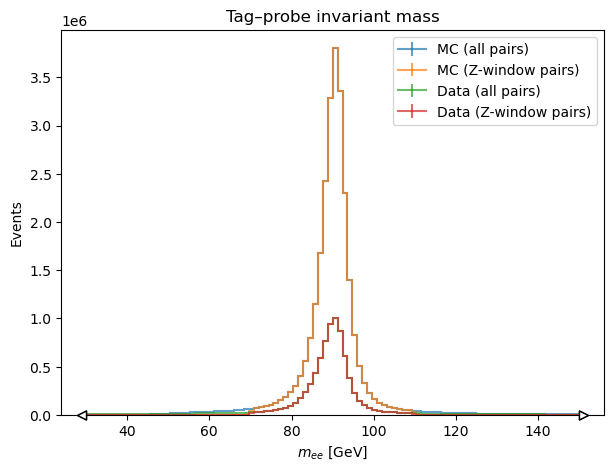

data # of overlap tag and probe: 0
mc # of overlap tag and probe: 0


In [12]:
# invariant mass check for the e pairs
data_h_mll_all  = ds_data["h_mll_all"]   
data_h_mll_good = ds_data["h_mll_good"]
mc_h_mll_all  = mc_sum("h_mll_all")   
mc_h_mll_good = mc_sum("h_mll_good")

fig, ax = plt.subplots(figsize=(7,5))
mc_h_mll_all.plot(ax=ax, label="MC (all pairs)", histtype="step", alpha=0.7)
mc_h_mll_good.plot(ax=ax, label="MC (Z-window pairs)", histtype="step", alpha=0.7)

data_h_mll_all.plot(ax=ax, label="Data (all pairs)", histtype="step", alpha=0.7)
data_h_mll_good.plot(ax=ax,label="Data (Z-window pairs)",histtype="step", alpha=0.7)

ax.set_xlabel(r"$m_{ee}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("Tag–probe invariant mass")
#plt.yscale("log")
ax.legend()
plt.show()

# check tag and probe do not overlap
data_n_same_tag_probe = ds_data["n_same_tag_probe"]
mc_n_same_tag_probe = mc_sum_scalar("n_same_tag_probe")
print("data # of overlap tag and probe:", data_n_same_tag_probe)
print("mc # of overlap tag and probe:", mc_n_same_tag_probe)


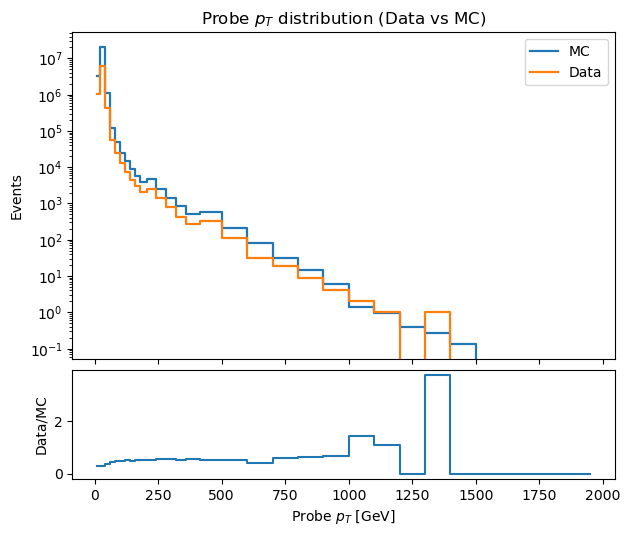

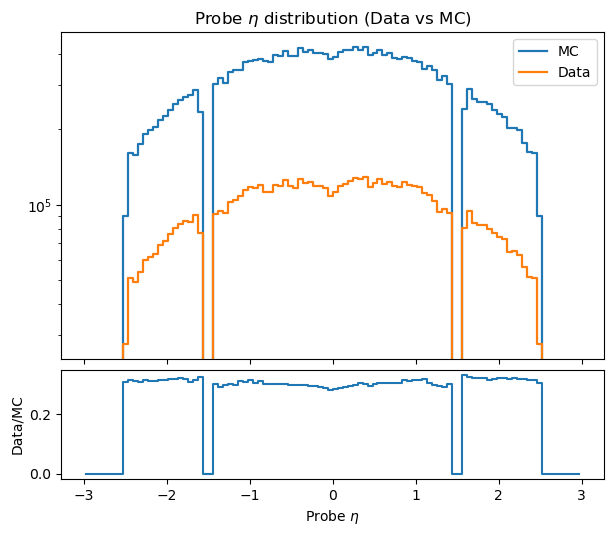

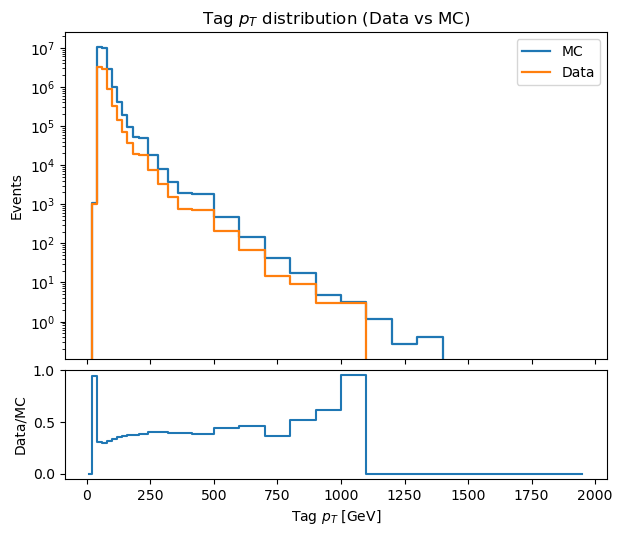

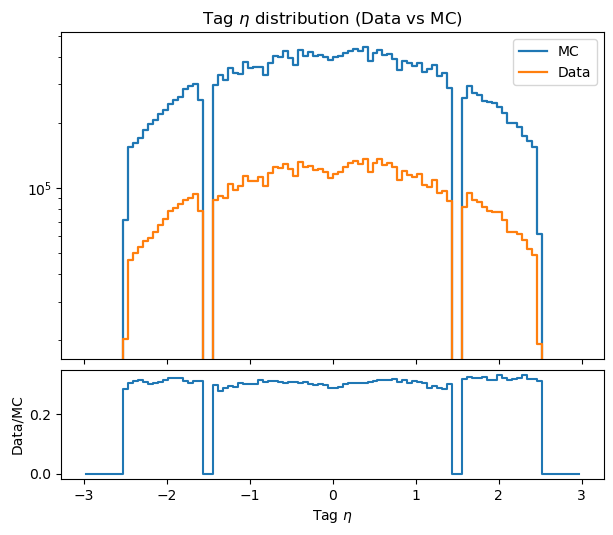

In [13]:
mc_probe_pt  = mc_sum("h_probe_pt")
mc_probe_eta = mc_sum("h_probe_eta")
data_probe_pt  = ds_data["h_probe_pt"]
data_probe_eta = ds_data["h_probe_eta"]

mc_tag_pt  = mc_sum("h_tag_pt")
mc_tag_eta = mc_sum("h_tag_eta")
data_tag_pt  = ds_data["h_tag_pt"]
data_tag_eta = ds_data["h_tag_eta"]

plot_data_mc_with_ratio(
    data_probe_pt, mc_probe_pt,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Probe $p_T$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    #density=True,
    #pt_plot=True,
)

plot_data_mc_with_ratio(
    data_probe_eta, mc_probe_eta,
    xlabel=r"Probe $\eta$",
    title=r"Probe $\eta$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    #density=True
)


plot_data_mc_with_ratio(
    data_tag_pt, mc_tag_pt,
    xlabel=r"Tag $p_T$ [GeV]",
    title=r"Tag $p_T$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    #density=True,
    #pt_plot=True,
)
plot_data_mc_with_ratio(
    data_tag_eta, mc_tag_eta,
    xlabel=r"Tag $\eta$",
    title=r"Tag $\eta$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    #density=True
)


In [24]:
# assumes: from hist import Hist, axis, storage, loc

POS = loc(1)
NEG = loc(-1)
from scipy.optimize import curve_fit

def apply_common_cuts(
            h_pairs: Hist,
            probe_region: str | None = None,        # None / "barrel" / "endcap"
            tag_ptbin: str | None = None,      # None / "35to100" / "lt100"
            tag_region: str | None = None,    # None / "barrel" / "endcap"
        ) -> Hist:
            hsel = h_pairs
        
            # probe region (barrel/endcap)
            if probe_region == "barrel":
                hsel = hsel[{"probe_is_barrel": loc(1)}]  
            elif probe_region == "endcap":
                hsel = hsel[{"probe_is_barrel": loc(0)}]
        
            # Tag pT bin 
            if tag_ptbin in ("35to100", "lt100"):
                hsel = hsel[{"tag_ptbin": tag_ptbin}]

            # tag region (barrel/endcap)
            if tag_region == "barrel":
                hsel = hsel[{"tag_is_barrel": loc(1)}]
            elif tag_region == "endcap":
                hsel = hsel[{"tag_is_barrel": loc(0)}]
        
            return hsel



def counts_by_quadrant(
            hsel: Hist,
            xaxis: str,
            tag_charge: str | None = None,   # None / "plus" / "minus"
        ) -> dict[str, Hist]:

            if tag_charge is None:
                h_pp        = hsel[{"tag_q": POS, "probe_q": POS}].project(xaxis)
                h_mm        = hsel[{"tag_q": NEG, "probe_q": NEG}].project(xaxis)
                h_pm_posneg = hsel[{"tag_q": POS, "probe_q": NEG}].project(xaxis)
                h_pm_negpos = hsel[{"tag_q": NEG, "probe_q": POS}].project(xaxis)
        
                h_pm = h_pm_posneg.copy()
                h_pm += h_pm_negpos
        
                h_same = h_pp.copy()
                h_same += h_mm
        
                h_tot = h_same.copy()
                h_tot += h_pm
        
                return {"pp": h_pp, "mm": h_mm, "pm": h_pm, "same": h_same, "tot": h_tot}
                
            # tag+
            if tag_charge == "plus":
                h_pp = hsel[{"tag_q": POS, "probe_q": POS}].project(xaxis)
                h_pm = hsel[{"tag_q": POS, "probe_q": NEG}].project(xaxis)
        
                h_mm = h_pp.copy()
                v = h_mm.view(flow=True)
                v["value"][...] = 0.0
                v["variance"][...] = 0.0
        
                h_same = h_pp.copy()
                h_tot = h_pp.copy()
                h_tot += h_pm
        
                return {"pp": h_pp, "mm": h_mm, "pm": h_pm, "same": h_same, "tot": h_tot}
        
            #  tag− 
            if tag_charge == "minus":
                h_mm = hsel[{"tag_q": NEG, "probe_q": NEG}].project(xaxis)
                h_pm = hsel[{"tag_q": NEG, "probe_q": POS}].project(xaxis)

                h_pp = h_mm.copy()
                v = h_pp.view(flow=True)
                v["value"][...] = 0.0
                v["variance"][...] = 0.0
        
                h_same = h_mm.copy()
                h_tot = h_mm.copy()
                h_tot += h_pm
        
                return {"pp": h_pp, "mm": h_mm, "pm": h_pm, "same": h_same, "tot": h_tot}



def ratio_vals(num: Hist, den: Hist):
    n = num.values()
    d = den.values()
    return np.divide(n, d, out=np.zeros_like(n, dtype=float), where=d > 0)


def build_eps_hists(
    h_pairs: Hist,
    xaxis: str,                 
    probe_region: str | None = None,   
    tag_charge: str | None = None,
    tag_ptbin: str | None = None,
    tag_region: str | None = None, 
):
    #ε1 = (pp + mm) / (pp + mm + pm)
    #ε2 =  pp / (pp + mm)
    #ε3 = pp  / (pp + mm + pm)
    #ε4 = mm  / (pp + mm + pm)
    hsel = apply_common_cuts(h_pairs, probe_region=probe_region, tag_ptbin=tag_ptbin, tag_region=tag_region)
    quads = counts_by_quadrant(hsel, xaxis, tag_charge=tag_charge)

    eps1_vals = ratio_vals(quads["same"], quads["tot"])
    eps2_vals = ratio_vals(quads["pp"],   quads["same"])
    eps3_vals = ratio_vals(quads["pp"], quads["tot"])
    eps4_vals = ratio_vals(quads["mm"], quads["tot"])

    pp  = quads["pp"].values()
    mm  = quads["mm"].values()
    pm  = quads["pm"].values()
    vpp = quads["pp"].variances()
    vmm = quads["mm"].variances()
    vpm = quads["pm"].variances()

    S  = pp + mm
    vS = vpp + vmm
    T  = S + pm


    eps1_var = np.divide(pm**2 * vS + S**2 * vpm, T**4, out=np.zeros_like(S, dtype=float), where=T > 0)
    eps2_var = np.divide(mm**2 * vpp + pp**2 * vmm, S**4, out=np.zeros_like(S, dtype=float), where=S > 0)
    eps3_var = np.divide((mm + pm)**2 * vpp + pp**2 * (vmm + vpm), T**4, out=np.zeros_like(S, dtype=float), where=T > 0)
    eps4_var = np.divide((pp + pm)**2 * vmm + mm**2 * (vpp + vpm), T**4, out=np.zeros_like(S, dtype=float), where=T > 0)

    ax = hsel.axes[xaxis]
    eps1_hist = Hist(ax, storage=storage.Weight())
    eps2_hist = Hist(ax, storage=storage.Weight())
    eps3_hist = Hist(ax, storage=storage.Weight())
    eps4_hist = Hist(ax, storage=storage.Weight())


    v = eps1_hist.view(flow=False)
    v["value"][...] = eps1_vals
    v["variance"][...] = eps1_var
    
    v = eps2_hist.view(flow=False)
    v["value"][...] = eps2_vals
    v["variance"][...] = eps2_var
    
    v = eps3_hist.view(flow=False)
    v["value"][...] = eps3_vals
    v["variance"][...] = eps3_var
    
    v = eps4_hist.view(flow=False)
    v["value"][...] = eps4_vals
    v["variance"][...] = eps4_var

    return eps1_hist, eps2_hist, eps3_hist, eps4_hist


def plot_eps_data_mc_with_ratio(
    h_data_eps: Hist,
    h_mc_eps: Hist,
    xlabel: str,
    title: str,
    ylim=(0, 0.45),
    ratio_ylim=(0, 5),
    do_fit = False,
    ratio_line = False
):
    centers = h_mc_eps.axes[0].centers
    d_vals = h_data_eps.values()
    m_vals = h_mc_eps.values()
    
    d_var = h_data_eps.variances()
    m_var = h_mc_eps.variances()
    
    d_err = np.sqrt(d_var)
    m_err = np.sqrt(m_var)
    
    ratio = np.divide(d_vals, m_vals,
                      out=np.zeros_like(d_vals, dtype=float),
                      where=m_vals > 0)

    ratio_var = (
        np.divide(d_var, m_vals**2, out=np.zeros_like(d_vals, dtype=float), where=m_vals > 0)
        + np.divide(d_vals**2 * m_var, m_vals**4, out=np.zeros_like(d_vals, dtype=float), where=m_vals > 0)
    )
    
    ratio_err = np.sqrt(ratio_var)

    if do_fit:
        def const_func(x, c):
            return c
    
        popt, pcov = curve_fit(const_func, centers, ratio, sigma=ratio_err, absolute_sigma=True)
        intercept = popt[0]
        intercept_err = float(np.sqrt(pcov[0, 0]))
        xline = np.array([centers.min(), centers.max()])
        yline = np.array([intercept, intercept])
        yband_lo = intercept - intercept_err
        yband_hi = intercept + intercept_err
        


    fig = plt.figure(figsize=(7, 5.8))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
    ax = fig.add_subplot(gs[0])
    rax = fig.add_subplot(gs[1], sharex=ax)

    ax.step(centers, m_vals, where="mid", linewidth=1.6, label="MC")
    ax.step(centers, d_vals, where="mid", linewidth=1.6, label="Data")
    ax.errorbar(centers, m_vals, yerr=m_err, fmt="o", markersize=3, capsize=2, label="MC", alpha=0.5)
    ax.errorbar(centers, d_vals, yerr=d_err, fmt="o", markersize=3, capsize=2, label="Data", alpha=0.5)
    
    if ylim is not None:
        ax.set_ylim(*ylim)
        
    ax.set_ylabel(r"$\epsilon$")
    ax.set_title(title)
    ax.legend()
    rax.step(centers, ratio, where="mid")
    rax.errorbar(centers, ratio, yerr=ratio_err, fmt="o", markersize=3, capsize=2, alpha=0.5)
    
    if do_fit:
        rax.plot(xline, yline, linewidth=1.2,label=rf"intercept: {intercept:.3g} ± {intercept_err:.3g}",color="orange")
        #rax.fill_between(xline, yband_lo, yband_hi, alpha=0.2, color="orange")
        rax.legend()
    if ratio_line:
        rax.axhline(1.0, linewidth=1.2, linestyle="--",color="orange")
    if ratio_ylim is not None:
        rax.set_ylim(*ratio_ylim)
    rax.set_ylabel("Data/MC")
    rax.set_xlabel(xlabel)
    plt.setp(ax.get_xticklabels(), visible=False)
    #plt.tight_layout()
    plt.show()

/tmp/ipykernel_23995/658845119.py:196: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(const_func, centers, ratio, sigma=ratio_err, absolute_sigma=True)


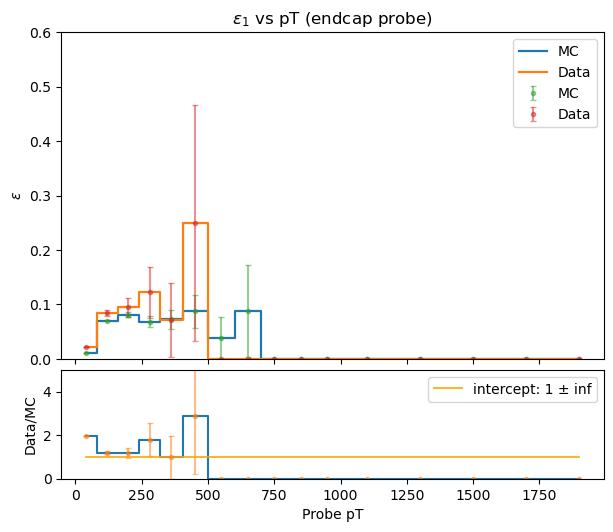

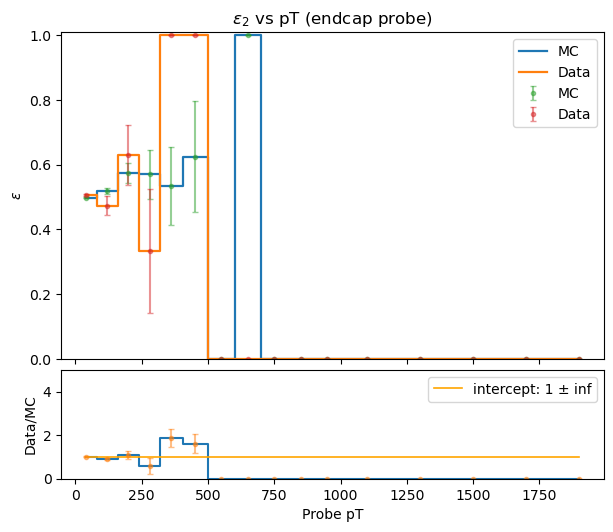

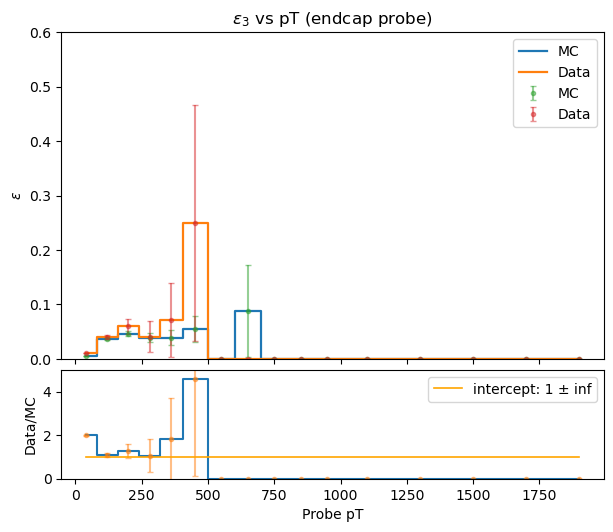

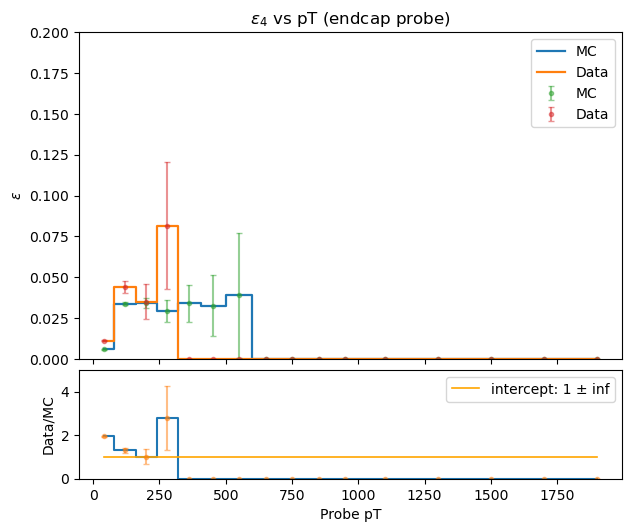

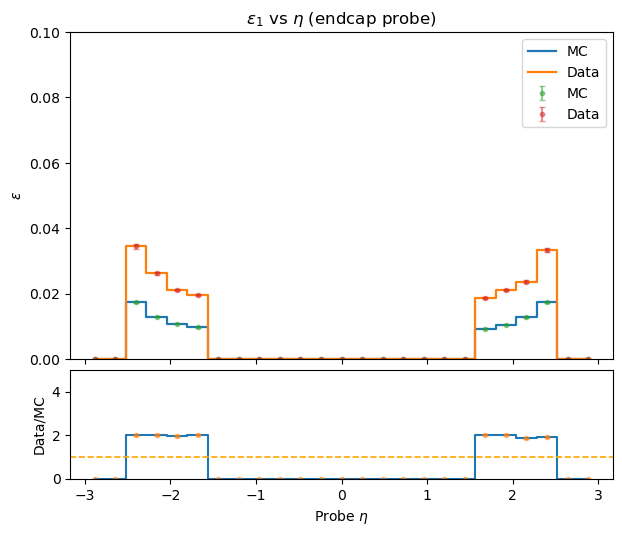

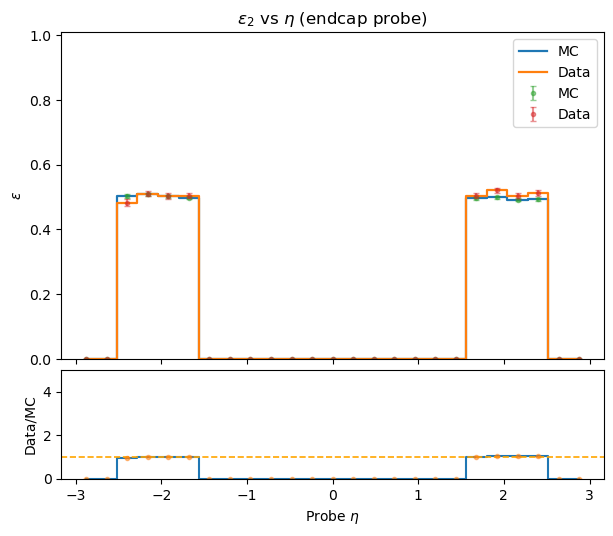

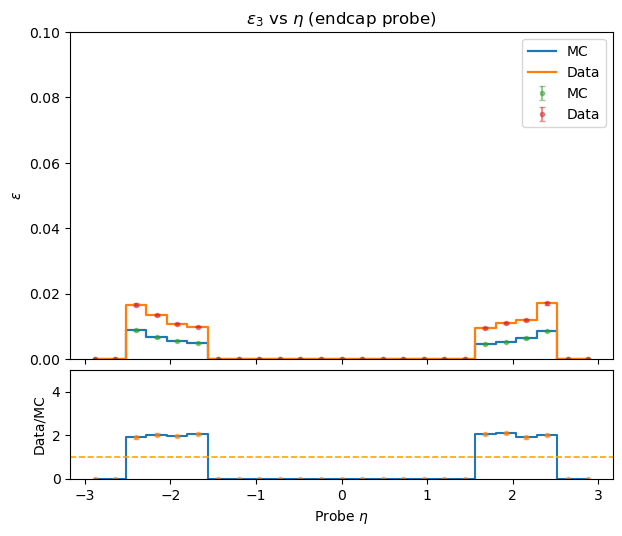

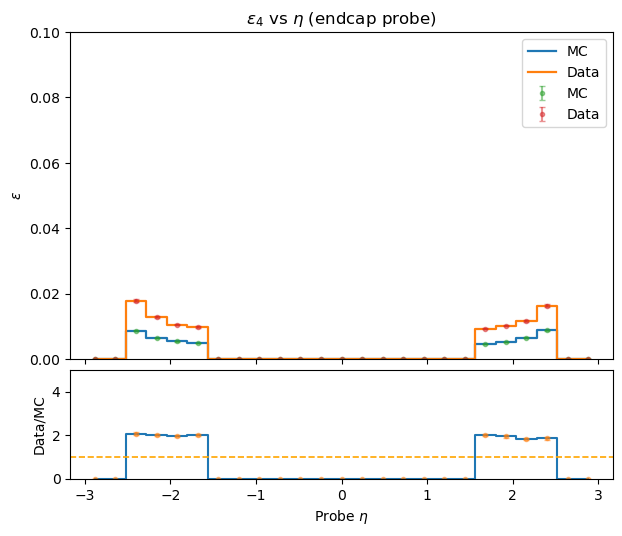

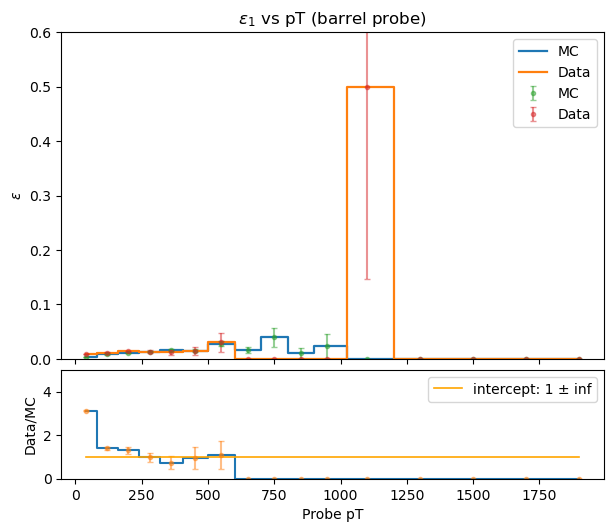

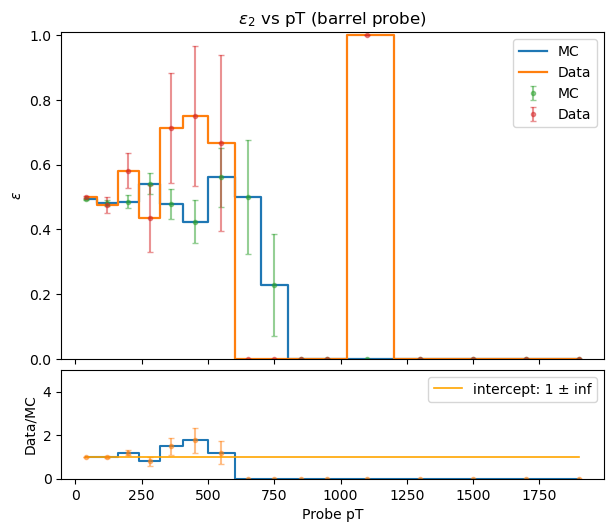

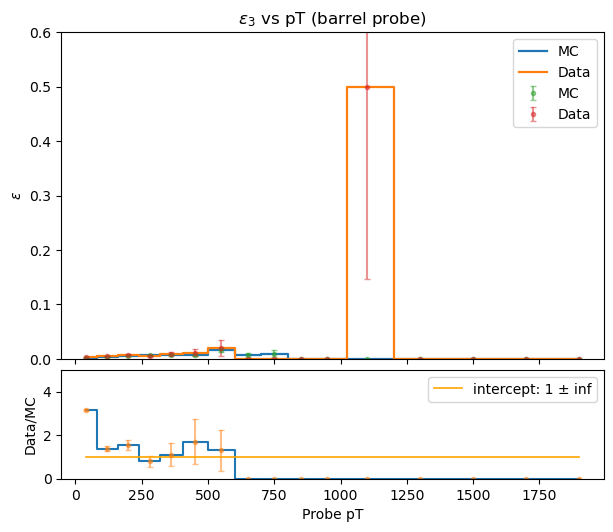

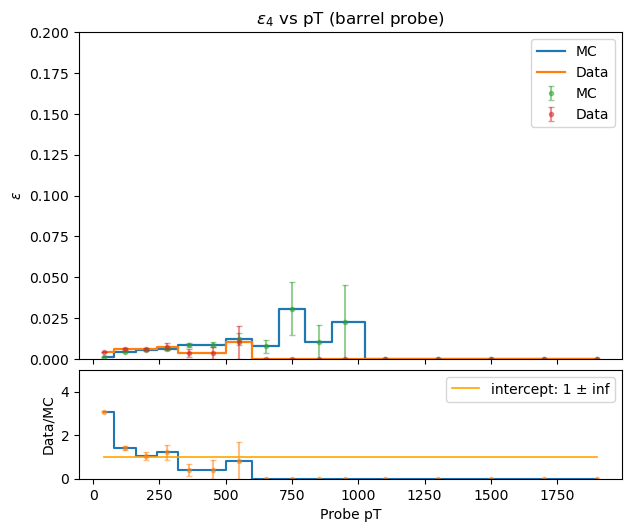

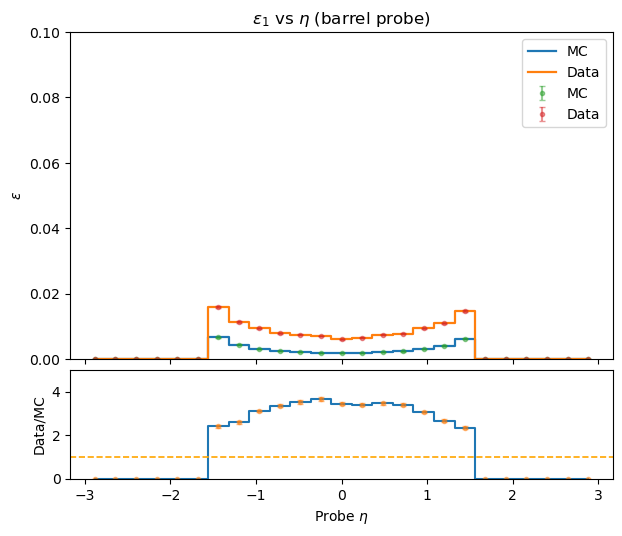

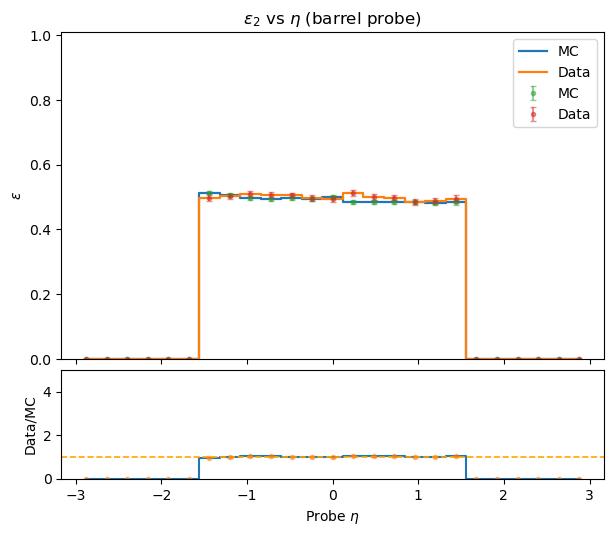

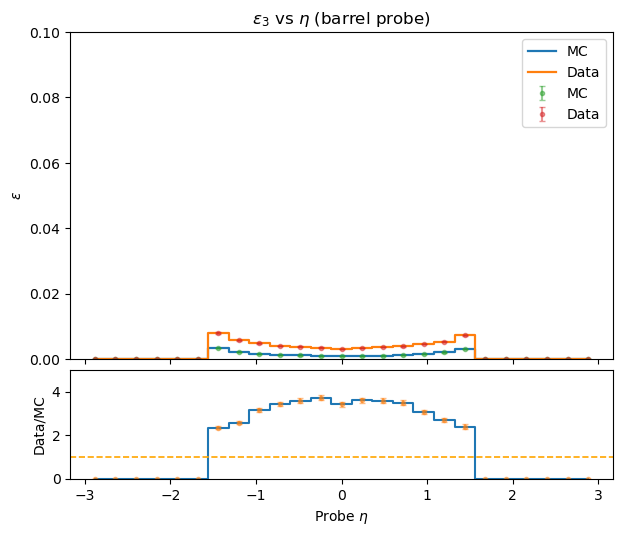

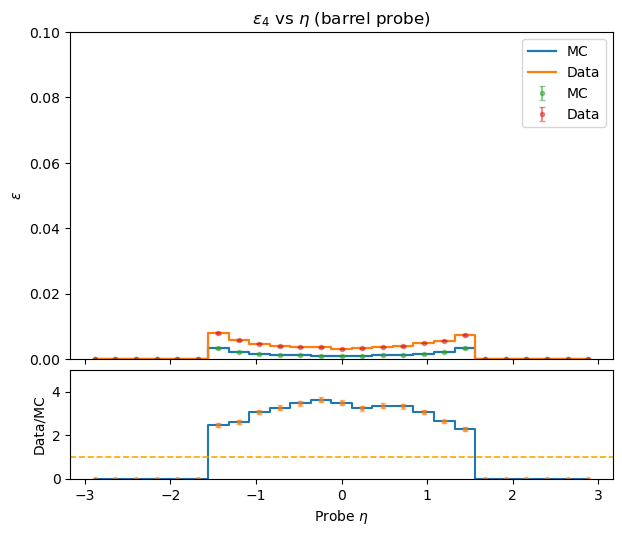

In [25]:
def rebin_variable_axis(h, axis_name, new_edges):
    ax_idx = None
    old_axis = None
    for i, ax in enumerate(h.axes):
        if ax.name == axis_name:
            ax_idx = i
            old_axis = ax
            break       
    old_edges = np.asarray(old_axis.edges)

    old_vals = h.view(flow=False) 
    vals_moved = np.moveaxis(old_vals, ax_idx, -1)
    n_new = len(new_edges) - 1
    new_shape = vals_moved.shape[:-1] + (n_new,)
    new_vals_moved = np.zeros(new_shape, dtype=vals_moved.dtype)

    for j in range(n_new):
        lo = new_edges[j]
        hi = new_edges[j + 1]
        k_lo = np.where(old_edges == lo)[0][0]
        k_hi = np.where(old_edges == hi)[0][0] 
        new_vals_moved[..., j] = vals_moved[..., k_lo:k_hi].sum(axis=-1)

    new_vals = np.moveaxis(new_vals_moved, -1, ax_idx)
    new_axes = list(h.axes)
    new_axes[ax_idx] = axis.Variable(new_edges, name=old_axis.name, label=old_axis.label)
    h_new = Hist(*new_axes, storage=storage.Weight())
    h_new.view(flow=False)[...] = new_vals
    return h_new

def rebin_probe_pt_eta(h_pairs, pt_edges, eta_factor):
    h_eta_rebinned = h_pairs[{"probe_eta": hist.rebin(eta_factor)}]
    h_eta_pt_rebinned = rebin_variable_axis(h_eta_rebinned, "probe_pt", pt_edges)
    return h_eta_pt_rebinned



data_pairs_raw  = ds_data["h_pairs"]   
mc_pairs_raw = mc_sum("h_pairs")

new_pt_edges = np.array([
    0, 80, 160,
    240, 320, 400,
    500, 600, 700, 800, 900, 1000, 
    1200, 1400, 1600, 1800, 2000,
])

data_pairs = rebin_probe_pt_eta(data_pairs_raw, new_pt_edges, eta_factor=2)
mc_pairs   = rebin_probe_pt_eta(mc_pairs_raw,   new_pt_edges, eta_factor=2)

    #ε1 = (pp + mm) / (pp + mm + pm)
    #ε2 =  pp / (pp + mm)
    #ε3 = pp  / (pp + mm + pm)
    #ε4 = mm  / (pp + mm + pm)

# barrel and endcap
dt_eps1_pt_ec, dt_eps2_pt_ec, dt_eps3_pt_ec, dt_eps4_pt_ec, = build_eps_hists(
    data_pairs, xaxis="probe_pt", probe_region="endcap", tag_charge=None, tag_ptbin=None, tag_region="barrel"
)
mc_eps1_pt_ec, mc_eps2_pt_ec, mc_eps3_pt_ec, mc_eps4_pt_ec = build_eps_hists(
    mc_pairs, xaxis="probe_pt", probe_region="endcap", tag_charge=None, tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_pt_ec, mc_eps1_pt_ec,
    xlabel=r"Probe pT",
    title = r"$\epsilon_1$ vs pT (endcap probe)",
    do_fit=True,
    ylim = (0,0.6),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_pt_ec, mc_eps2_pt_ec,
    xlabel=r"Probe pT",
    title=r"$\epsilon_2$ vs pT (endcap probe)",
    ylim = (0,1.01),
    do_fit=True

)

plot_eps_data_mc_with_ratio(
    dt_eps3_pt_ec, mc_eps3_pt_ec,
    xlabel=r"Probe pT",
    title=r"$\epsilon_3$ vs pT (endcap probe)",
    do_fit=True,
    ylim = (0,0.6),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_pt_ec, mc_eps4_pt_ec,
    xlabel=r"Probe pT",
    title=r"$\epsilon_4$ vs pT (endcap probe)",
    do_fit=True,
    ylim = (0,0.2),
)



dt_eps1_eta_ec, dt_eps2_eta_ec, dt_eps3_eta_ec, dt_eps4_eta_ec = build_eps_hists(
    data_pairs, xaxis="probe_eta", probe_region="endcap", tag_charge=None, tag_ptbin=None, tag_region="barrel"
)
mc_eps1_eta_ec, mc_eps2_eta_ec, mc_eps3_eta_ec, mc_eps4_eta_ec = build_eps_hists(
    mc_pairs, xaxis="probe_eta", probe_region="endcap", tag_charge=None, tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_eta_ec, mc_eps1_eta_ec,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_1$ vs $\eta$ (endcap probe)",
    ratio_line=True,
    ylim = (0,0.1)
)
plot_eps_data_mc_with_ratio(
    dt_eps2_eta_ec, mc_eps2_eta_ec,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_2$ vs $\eta$ (endcap probe)",
    ylim = (0,1.01),
    ratio_line=True
)

plot_eps_data_mc_with_ratio(
    dt_eps3_eta_ec, mc_eps3_eta_ec,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_3$ vs $\eta$ (endcap probe)",
    ratio_line=True,
    ylim = (0,0.1),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_eta_ec, mc_eps4_eta_ec,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_4$ vs $\eta$ (endcap probe)",
    ratio_line=True,
    ylim = (0,0.1),
)




dt_eps1_pt_b, dt_eps2_pt_b, dt_eps3_pt_b, dt_eps4_pt_b = build_eps_hists(
    data_pairs, xaxis="probe_pt", probe_region="barrel", tag_charge=None, tag_ptbin=None, tag_region="barrel"
)
mc_eps1_pt_b, mc_eps2_pt_b, mc_eps3_pt_b, mc_eps4_pt_b = build_eps_hists(
    mc_pairs, xaxis="probe_pt", probe_region="barrel", tag_charge=None, tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_pt_b, mc_eps1_pt_b,
    xlabel=r"Probe pT",
    title = r"$\epsilon_1$ vs pT (barrel probe)",
    ylim = (0,0.6),
    do_fit=True
)
plot_eps_data_mc_with_ratio(
    dt_eps2_pt_b, mc_eps2_pt_b,
    xlabel=r"Probe pT",
    title=r"$\epsilon_2$ vs pT (barrel probe)",
    ylim = (0,1.01),
    do_fit=True
)
plot_eps_data_mc_with_ratio(
    dt_eps3_pt_b, mc_eps3_pt_b,
    xlabel=r"Probe pT",
    title = r"$\epsilon_3$ vs pT (barrel probe)",
    ylim = (0,0.6),
    do_fit=True
)
plot_eps_data_mc_with_ratio(
    dt_eps4_pt_b, mc_eps4_pt_b,
    xlabel=r"Probe pT",
    title=r"$\epsilon_4$ vs pT (barrel probe)",
    do_fit=True,
    ylim = (0,0.2),
)



dt_eps1_eta_b, dt_eps2_eta_b, dt_eps3_eta_b, dt_eps4_eta_b = build_eps_hists(
    data_pairs, xaxis="probe_eta", probe_region="barrel", tag_charge=None, tag_ptbin=None, tag_region="barrel"
)
mc_eps1_eta_b, mc_eps2_eta_b, mc_eps3_eta_b, mc_eps4_eta_b = build_eps_hists(
    mc_pairs, xaxis="probe_eta", probe_region="barrel", tag_charge=None, tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_eta_b, mc_eps1_eta_b,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_1$ vs $\eta$ (barrel probe)",
    ratio_line=True,
    ylim = (0,0.1)
)
plot_eps_data_mc_with_ratio(
    dt_eps2_eta_b, mc_eps2_eta_b,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_2$ vs $\eta$ (barrel probe)",
    ylim = (0,1.01),
    ratio_line=True
)
plot_eps_data_mc_with_ratio(
    dt_eps3_eta_b, mc_eps3_eta_b,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_3$ vs $\eta$ (barrel probe)",
    ratio_line=True,
    ylim = (0,0.1),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_eta_b, mc_eps4_eta_b,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_4$ vs $\eta$ (barrel probe)",
    ratio_line=True,
    ylim = (0,0.1),
)

/tmp/ipykernel_23995/658845119.py:196: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(const_func, centers, ratio, sigma=ratio_err, absolute_sigma=True)


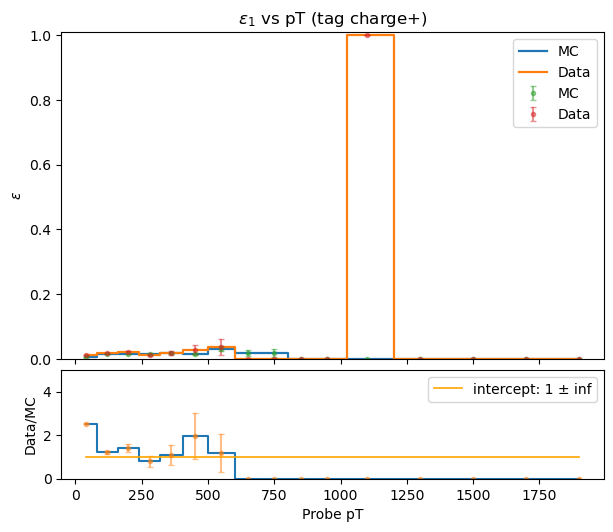

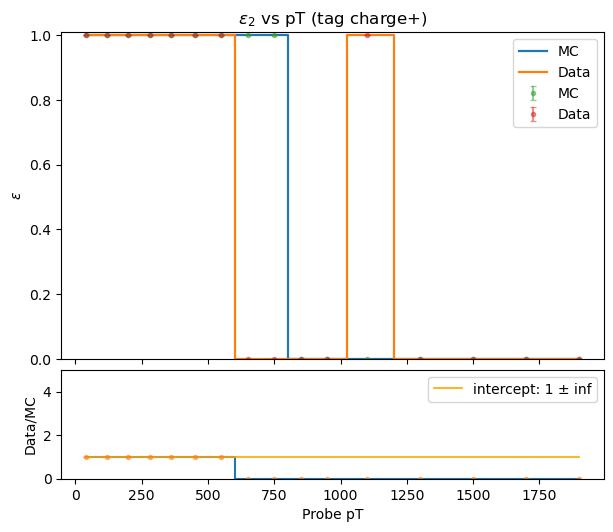

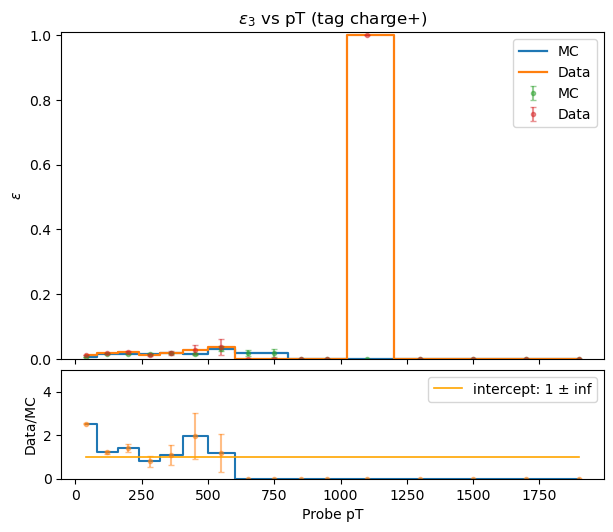

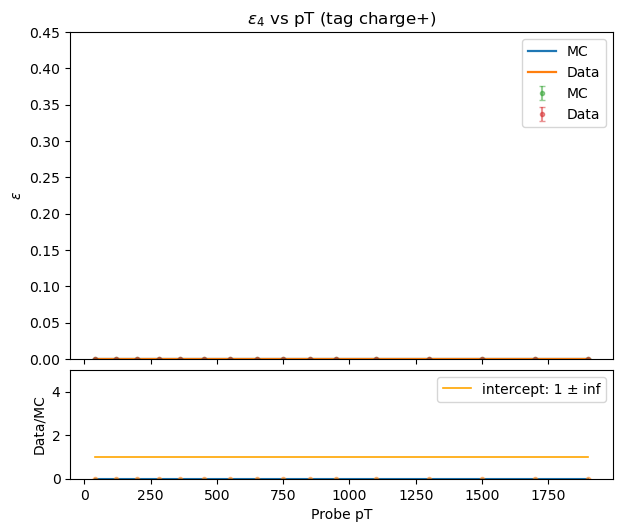

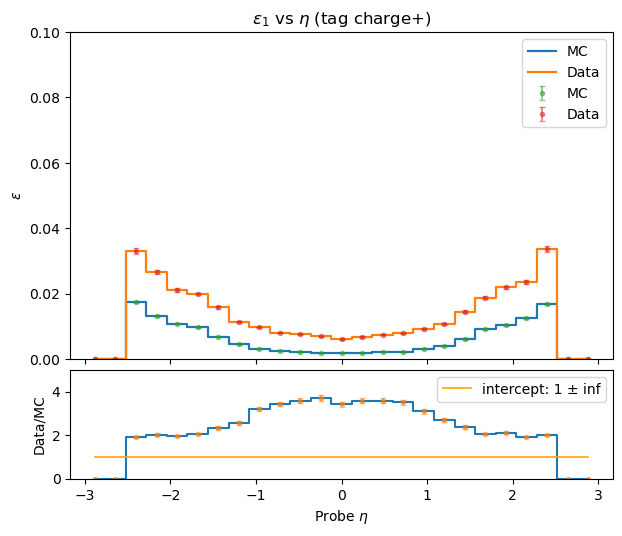

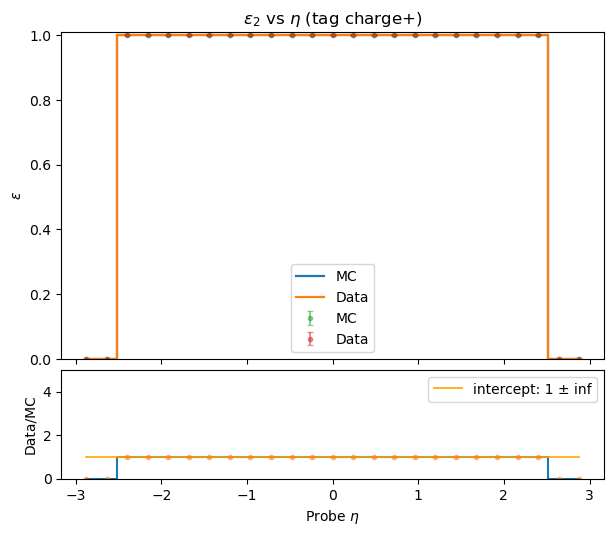

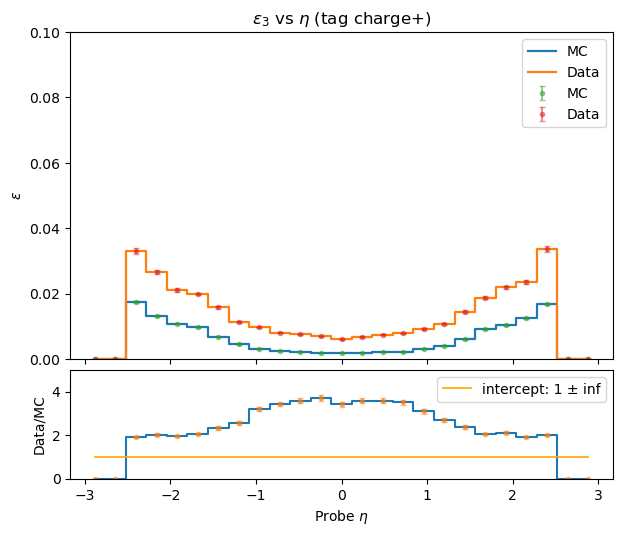

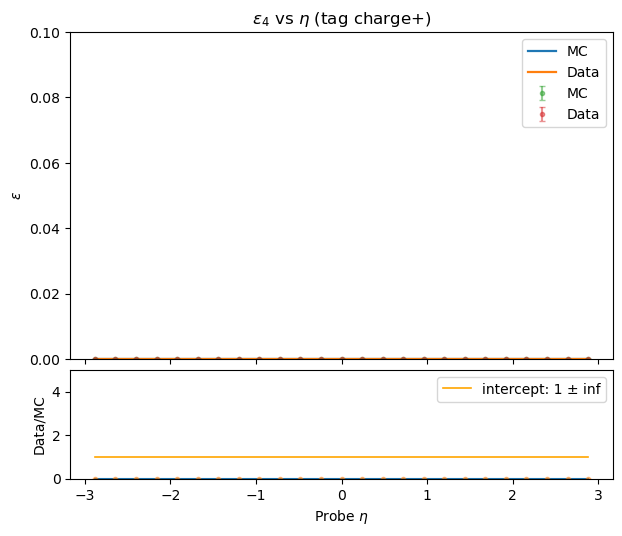

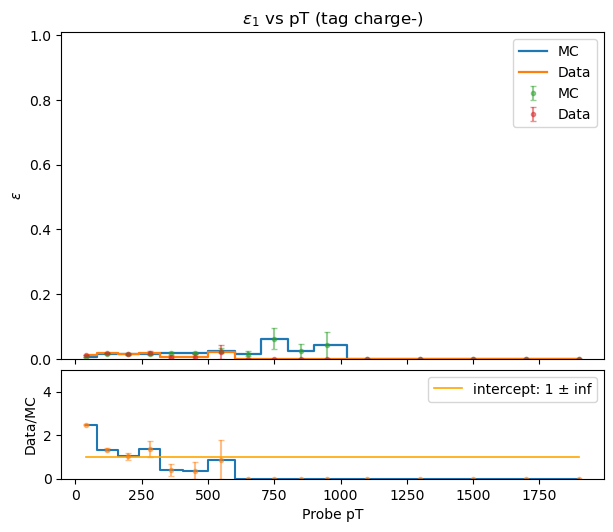

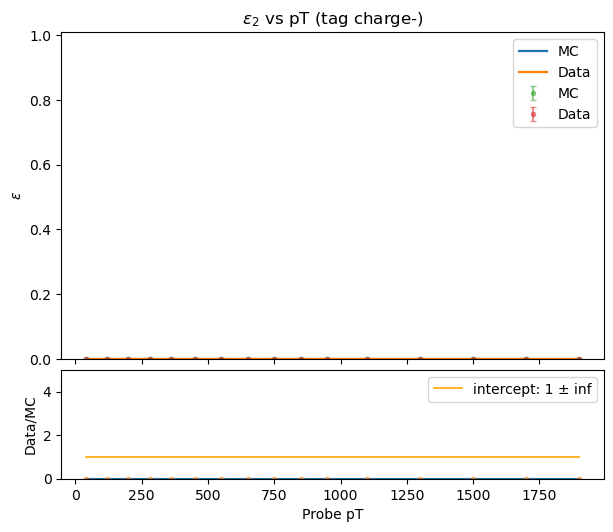

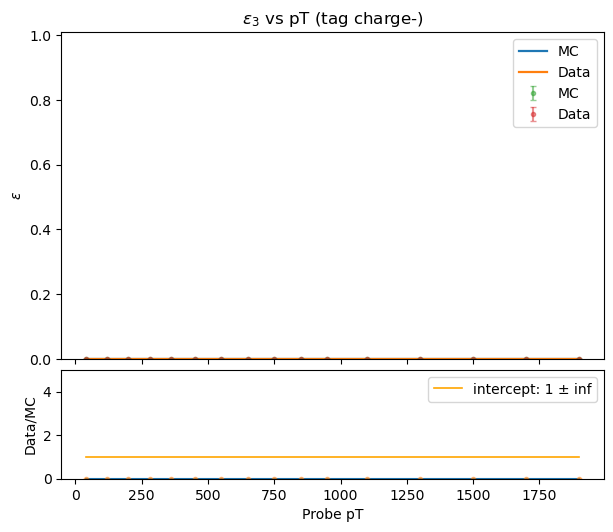

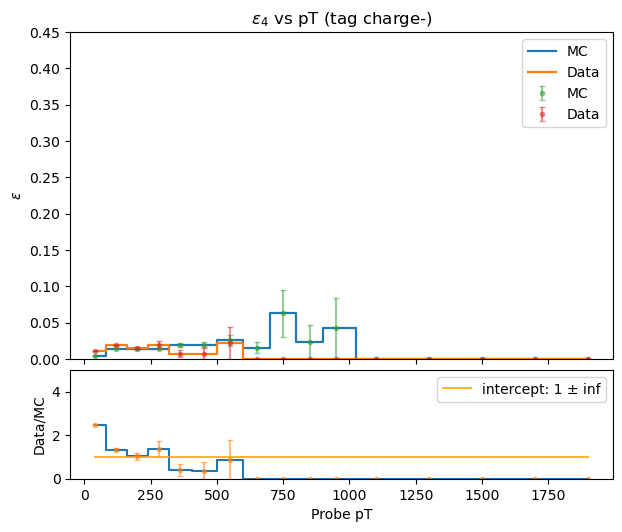

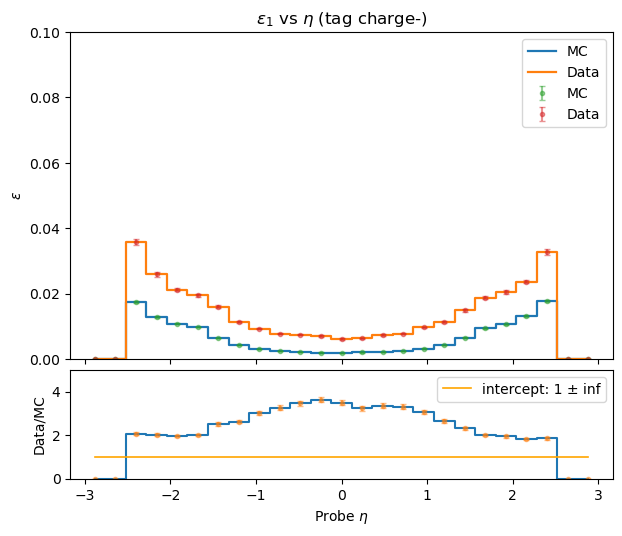

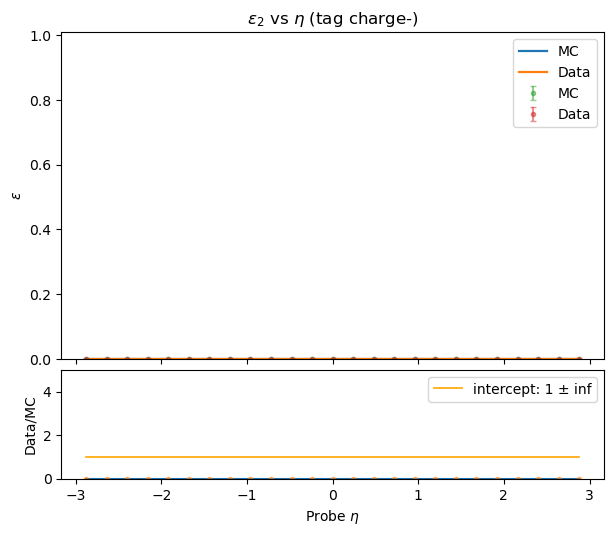

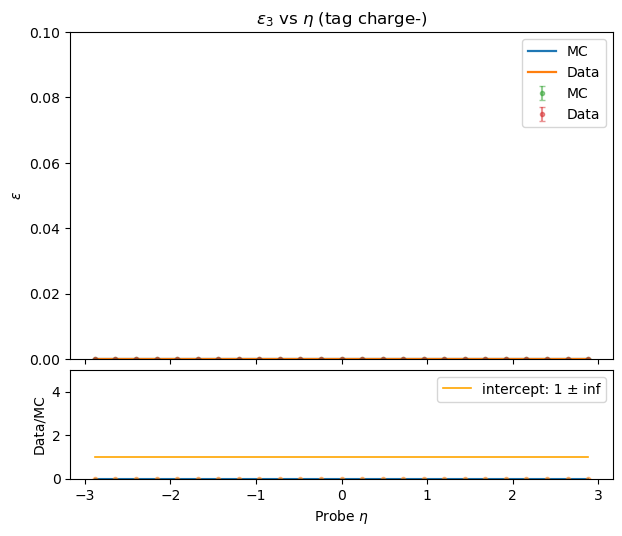

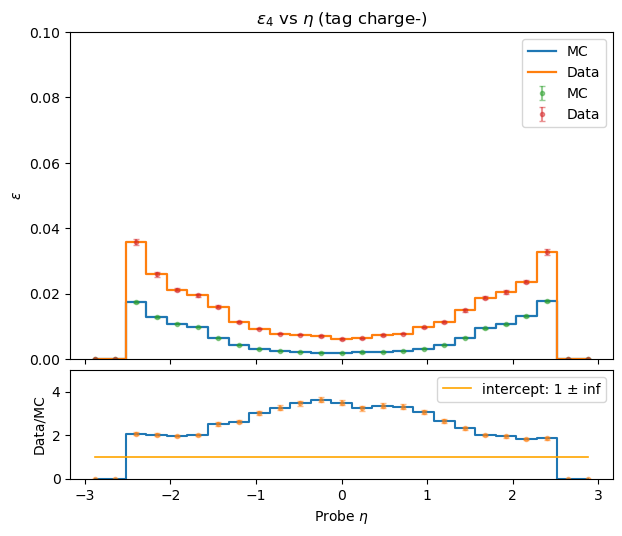

In [26]:
# tag charge

    #ε1 = (pp + mm) / (pp + mm + pm)
    #ε2 =  pp / (pp + mm)
    #ε3 = pp  / (pp + mm + pm)
    #ε4 = mm  / (pp + mm + pm)

dt_eps1_pt_plus, dt_eps2_pt_plus, dt_eps3_pt_plus, dt_eps4_pt_plus = build_eps_hists(
    data_pairs, xaxis="probe_pt", probe_region=None, tag_charge="plus", tag_ptbin=None, tag_region="barrel"
)
mc_eps1_pt_plus, mc_eps2_pt_plus, mc_eps3_pt_plus, mc_eps4_pt_plus = build_eps_hists(
    mc_pairs, xaxis="probe_pt", probe_region=None, tag_charge="plus", tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_pt_plus, mc_eps1_pt_plus,
    xlabel=r"Probe pT",
    title = r"$\epsilon_1$ vs pT (tag charge+)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_pt_plus, mc_eps2_pt_plus,
    xlabel=r"Probe pT",
    title=r"$\epsilon_2$ vs pT (tag charge+)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps3_pt_plus, mc_eps3_pt_plus,
    xlabel=r"Probe pT",
    title = r"$\epsilon_3$ vs pT (tag charge+)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_pt_plus, mc_eps4_pt_plus,
    xlabel=r"Probe pT",
    title=r"$\epsilon_4$ vs pT (tag charge+)",
    do_fit=True,
)




dt_eps1_eta_plus, dt_eps2_eta_plus, dt_eps3_eta_plus, dt_eps4_eta_plus = build_eps_hists(
    data_pairs, xaxis="probe_eta", probe_region=None, tag_charge="plus", tag_ptbin=None, tag_region="barrel"
)
mc_eps1_eta_plus, mc_eps2_eta_plus, mc_eps3_eta_plus, mc_eps4_eta_plus = build_eps_hists(
    mc_pairs, xaxis="probe_eta", probe_region=None, tag_charge="plus", tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_eta_plus, mc_eps1_eta_plus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_1$ vs $\eta$ (tag charge+)",
    do_fit=True,
    ylim = (0,0.1),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_eta_plus, mc_eps2_eta_plus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_2$ vs $\eta$ (tag charge+)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps3_eta_plus, mc_eps3_eta_plus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_3$ vs $\eta$ (tag charge+)",
    do_fit=True,
    ylim = (0,0.1),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_eta_plus, mc_eps4_eta_plus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_4$ vs $\eta$ (tag charge+)",
    do_fit=True,
    ylim = (0,0.1),
)


dt_eps1_pt_minus, dt_eps2_pt_minus, dt_eps3_pt_minus, dt_eps4_pt_minus = build_eps_hists(
    data_pairs, xaxis="probe_pt", probe_region=None, tag_charge="minus", tag_ptbin=None, tag_region="barrel"
)
mc_eps1_pt_minus, mc_eps2_pt_minus, mc_eps3_pt_minus, mc_eps4_pt_minus = build_eps_hists(
    mc_pairs, xaxis="probe_pt", probe_region=None, tag_charge="minus", tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_pt_minus, mc_eps1_pt_minus,
    xlabel=r"Probe pT",
    title = r"$\epsilon_1$ vs pT (tag charge-)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_pt_minus, mc_eps2_pt_minus,
    xlabel=r"Probe pT",
    title=r"$\epsilon_2$ vs pT (tag charge-)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps3_pt_minus, mc_eps3_pt_minus,
    xlabel=r"Probe pT",
    title = r"$\epsilon_3$ vs pT (tag charge-)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_pt_minus, mc_eps4_pt_minus,
    xlabel=r"Probe pT",
    title=r"$\epsilon_4$ vs pT (tag charge-)",
    do_fit=True,
)



dt_eps1_eta_minus, dt_eps2_eta_minus, dt_eps3_eta_minus, dt_eps4_eta_minus = build_eps_hists(
    data_pairs, xaxis="probe_eta", probe_region=None, tag_charge="minus", tag_ptbin=None, tag_region="barrel"
)
mc_eps1_eta_minus, mc_eps2_eta_minus, mc_eps3_eta_minus, mc_eps4_eta_minus = build_eps_hists(
    mc_pairs, xaxis="probe_eta", probe_region=None, tag_charge="minus", tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_eta_minus, mc_eps1_eta_minus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_1$ vs $\eta$ (tag charge-)",
    do_fit=True,
    ylim = (0,0.1),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_eta_minus, mc_eps2_eta_minus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_2$ vs $\eta$ (tag charge-)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps3_eta_minus, mc_eps3_eta_minus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_3$ vs $\eta$ (tag charge-)",
    do_fit=True,
    ylim = (0,0.1),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_eta_minus, mc_eps4_eta_minus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_4$ vs $\eta$ (tag charge-)",
    do_fit=True,
    ylim = (0,0.1),
)

/tmp/ipykernel_23995/658845119.py:196: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(const_func, centers, ratio, sigma=ratio_err, absolute_sigma=True)


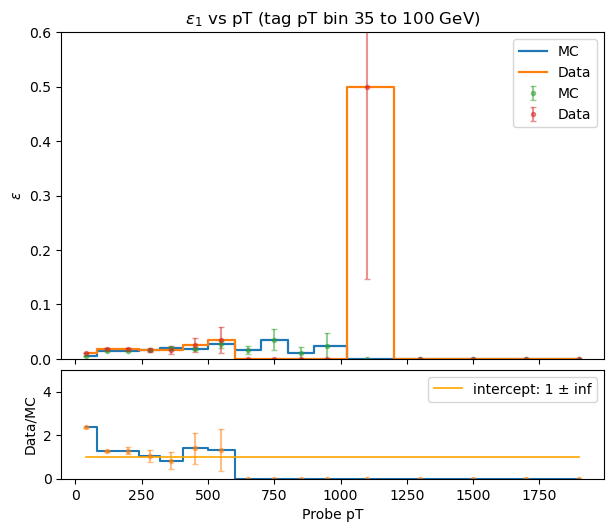

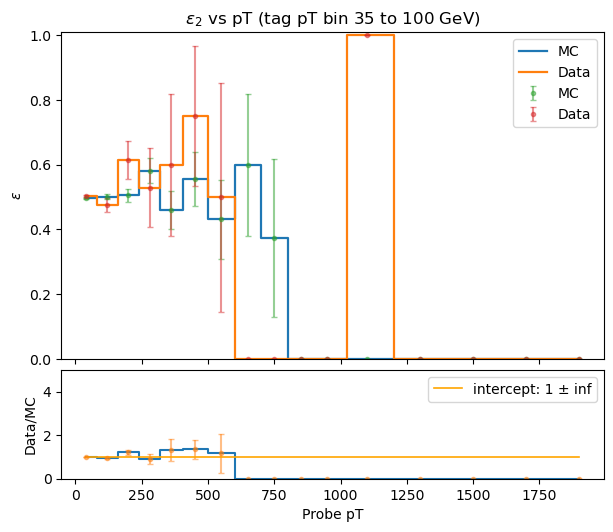

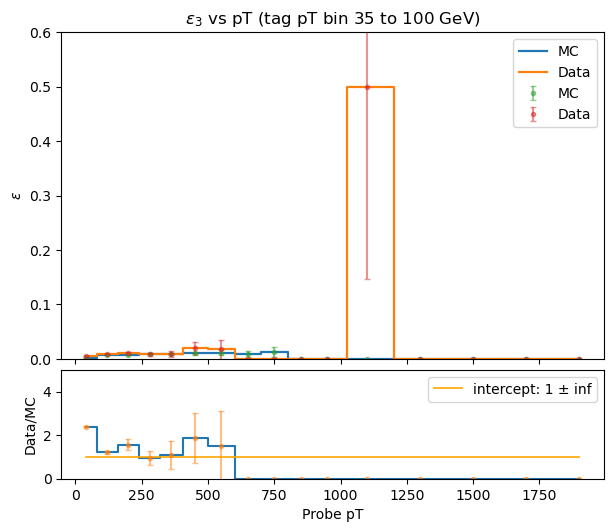

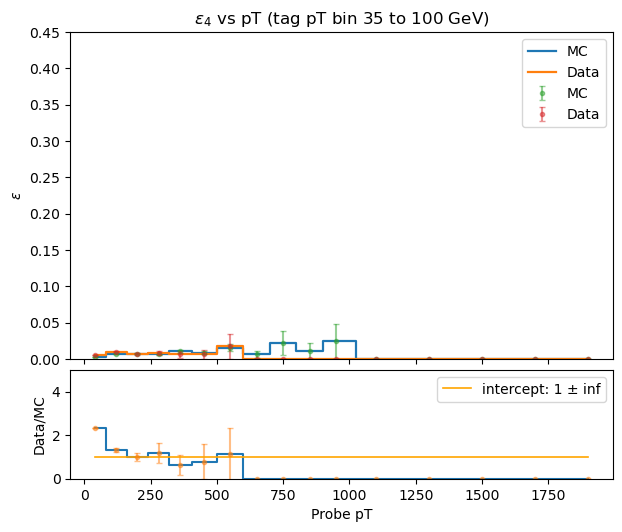

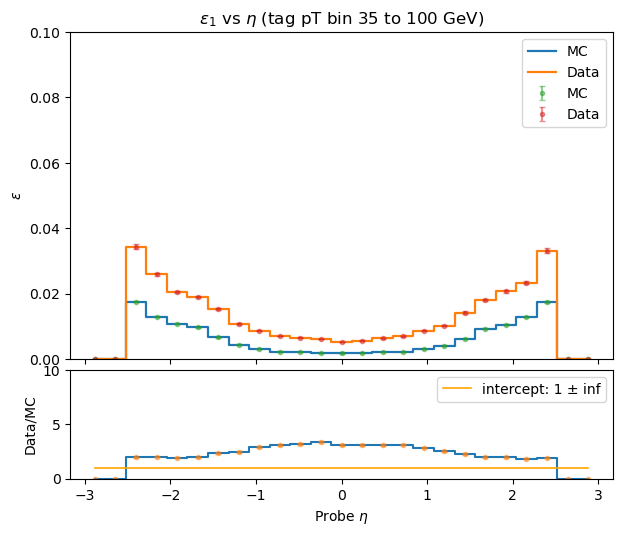

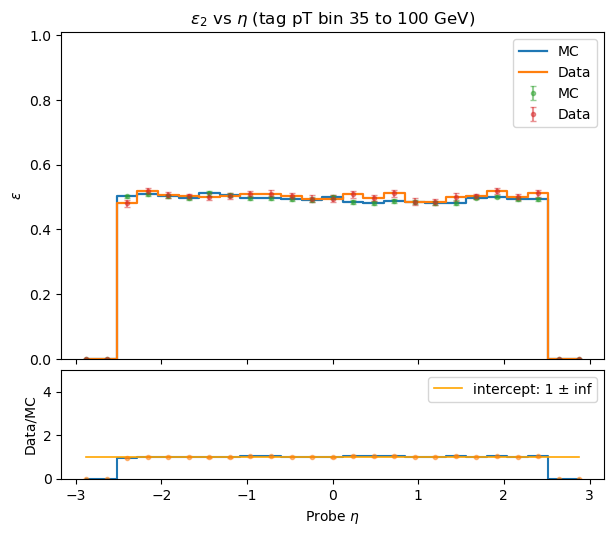

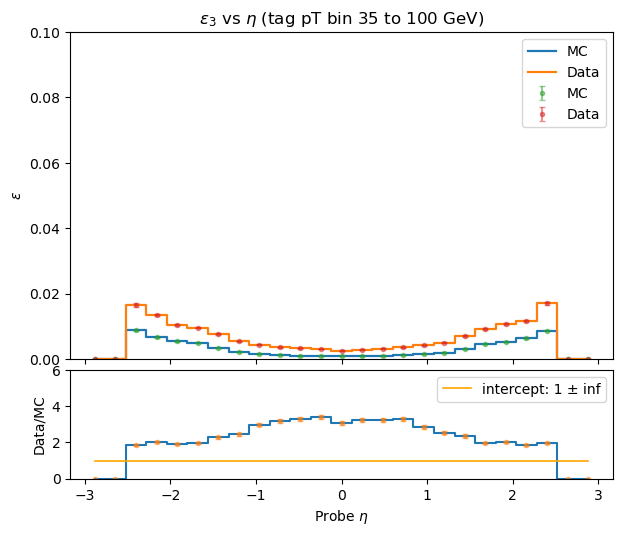

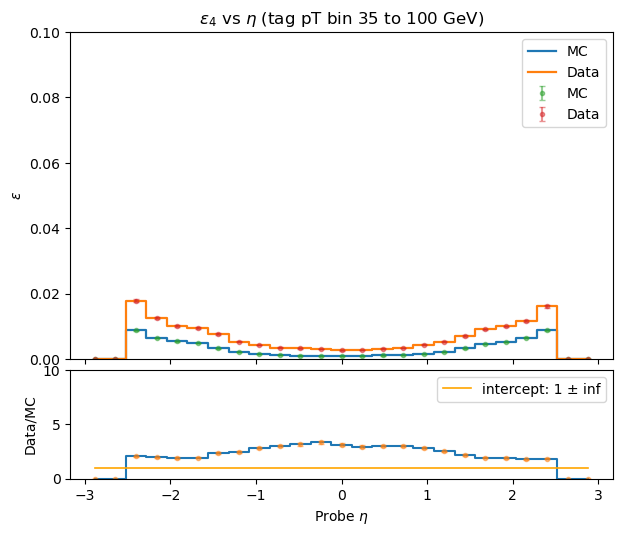

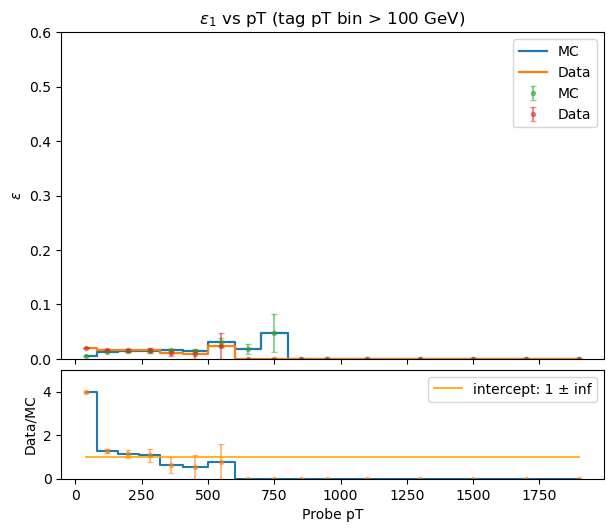

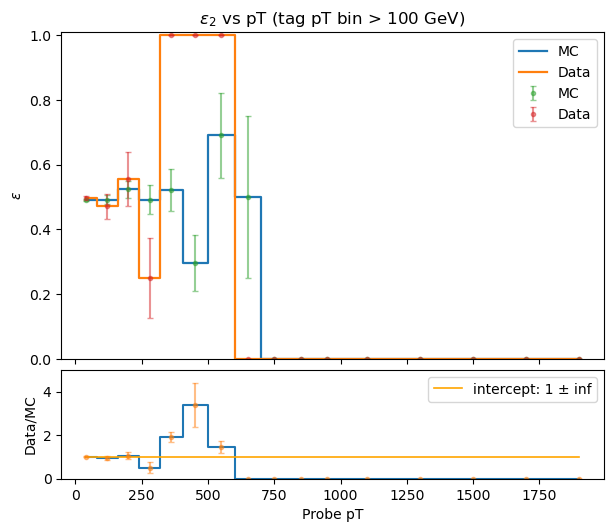

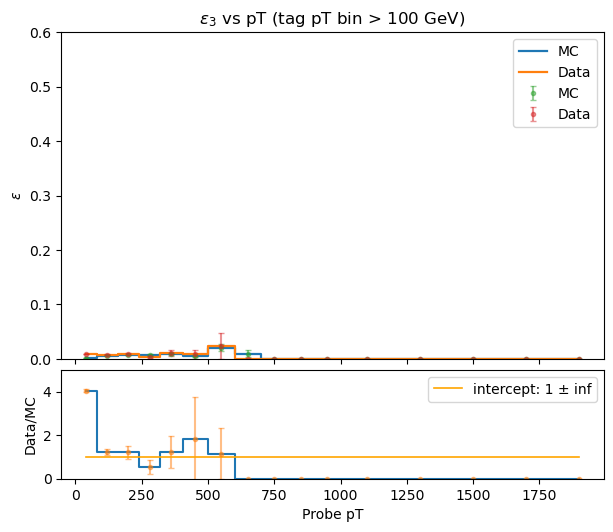

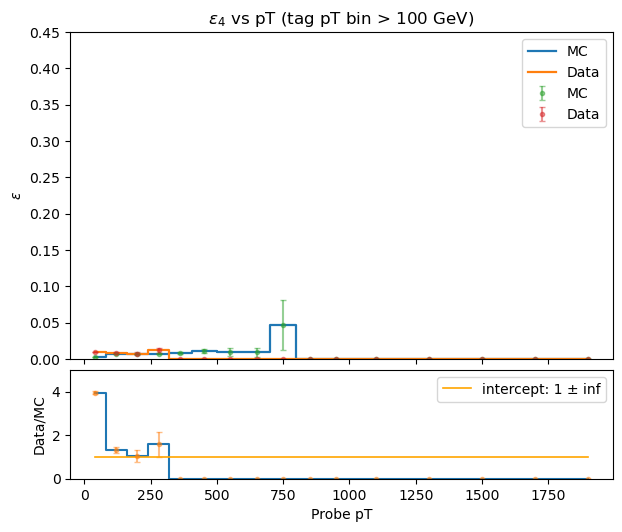

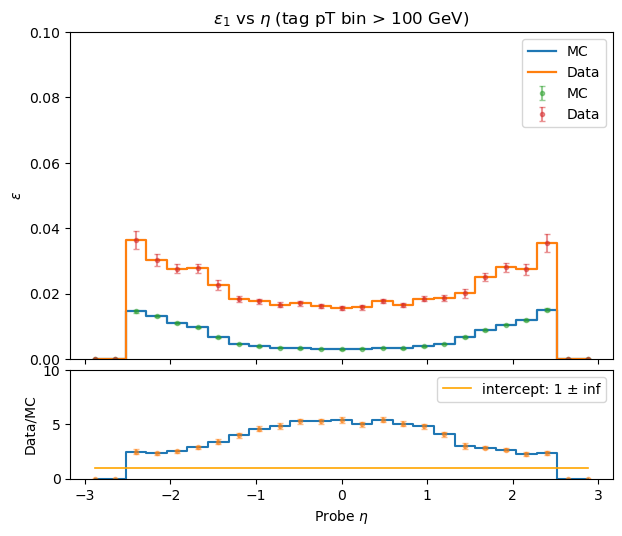

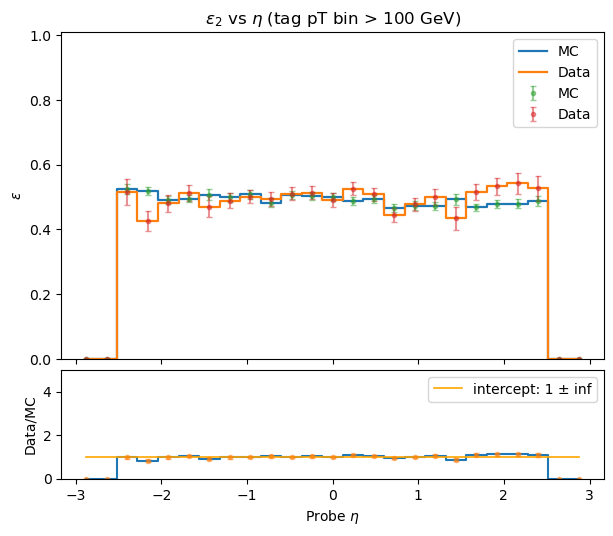

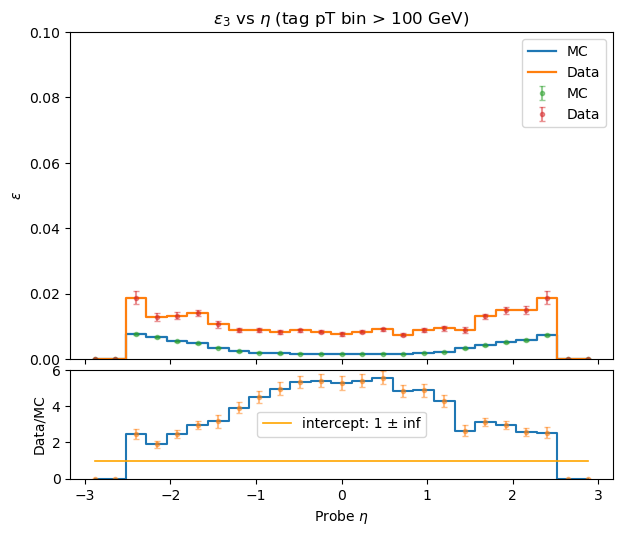

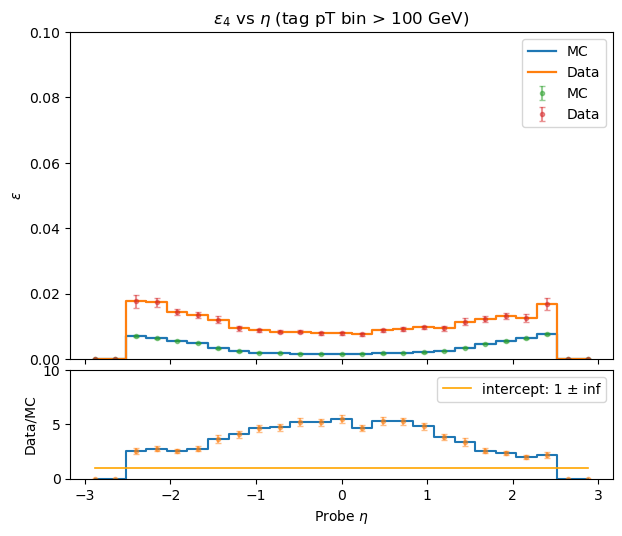

In [27]:
# tag pt bin

    #ε1 = (pp + mm) / (pp + mm + pm)
    #ε2 =  pp / (pp + mm)
    #ε3 = pp  / (pp + mm + pm)
    #ε4 = mm  / (pp + mm + pm)


dt_eps1_pt_s, dt_eps2_pt_s, dt_eps3_pt_s, dt_eps4_pt_s = build_eps_hists(
    data_pairs, xaxis="probe_pt", probe_region=None, tag_charge=None, tag_ptbin="35to100", tag_region="barrel"   
)
mc_eps1_pt_s, mc_eps2_pt_s, mc_eps3_pt_s, mc_eps4_pt_s = build_eps_hists(
    mc_pairs, xaxis="probe_pt", probe_region=None, tag_charge=None, tag_ptbin="35to100", tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_pt_s, mc_eps1_pt_s,
    xlabel=r"Probe pT",
    title = r"$\epsilon_1$ vs pT (tag pT bin 35 to 100 GeV)",
    do_fit=True,
    ylim = (0,0.6),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_pt_s, mc_eps2_pt_s,
    xlabel=r"Probe pT",
    title=r"$\epsilon_2$ vs pT (tag pT bin 35 to 100 GeV)",
    do_fit=True,
    ylim = (0,1.01)
)
plot_eps_data_mc_with_ratio(
    dt_eps3_pt_s, mc_eps3_pt_s,
    xlabel=r"Probe pT",
    title = r"$\epsilon_3$ vs pT (tag pT bin 35 to 100 GeV)",
    do_fit=True,
    ylim = (0,0.6),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_pt_s, mc_eps4_pt_s,
    xlabel=r"Probe pT",
    title=r"$\epsilon_4$ vs pT (tag pT bin 35 to 100 GeV)",
    do_fit=True,
)



dt_eps1_eta_s, dt_eps2_eta_s, dt_eps3_eta_s, dt_eps4_eta_s = build_eps_hists(
    data_pairs, xaxis="probe_eta", probe_region=None, tag_charge=None, tag_ptbin="35to100", tag_region="barrel"
)
mc_eps1_eta_s, mc_eps2_eta_s, mc_eps3_eta_s, mc_eps4_eta_s = build_eps_hists(
    mc_pairs, xaxis="probe_eta", probe_region=None, tag_charge=None, tag_ptbin="35to100", tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_eta_s, mc_eps1_eta_s,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_1$ vs $\eta$ (tag pT bin 35 to 100 GeV)",
    do_fit=True,
    ylim = (0,0.1),
    ratio_ylim=(0, 10),

)
plot_eps_data_mc_with_ratio(
    dt_eps2_eta_s, mc_eps2_eta_s,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_2$ vs $\eta$ (tag pT bin 35 to 100 GeV)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps3_eta_s, mc_eps3_eta_s,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_3$ vs $\eta$ (tag pT bin 35 to 100 GeV)",
    do_fit=True,
    ylim = (0,0.1),
    ratio_ylim=(0, 6),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_eta_s, mc_eps4_eta_s,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_4$ vs $\eta$ (tag pT bin 35 to 100 GeV)",
    do_fit=True,
    ylim = (0,0.1),
    ratio_ylim=(0, 10),
)


dt_eps1_pt_b, dt_eps2_pt_b, dt_eps3_pt_b, dt_eps4_pt_b = build_eps_hists(
    data_pairs, xaxis="probe_pt", probe_region=None, tag_charge=None, tag_ptbin="lt100", tag_region="barrel"
)
mc_eps1_pt_b, mc_eps2_pt_b, mc_eps3_pt_b, mc_eps4_pt_b = build_eps_hists(
    mc_pairs, xaxis="probe_pt", probe_region=None, tag_charge=None, tag_ptbin="lt100", tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_pt_b, mc_eps1_pt_b,
    xlabel=r"Probe pT",
    title = r"$\epsilon_1$ vs pT (tag pT bin > 100 GeV)",
    do_fit=True,
    ylim = (0,0.6),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_pt_b, mc_eps2_pt_b,
    xlabel=r"Probe pT",
    title=r"$\epsilon_2$ vs pT (tag pT bin > 100 GeV)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps3_pt_b, mc_eps3_pt_b,
    xlabel=r"Probe pT",
    title = r"$\epsilon_3$ vs pT (tag pT bin > 100 GeV)",
    do_fit=True,
    ylim = (0,0.6),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_pt_b, mc_eps4_pt_b,
    xlabel=r"Probe pT",
    title=r"$\epsilon_4$ vs pT (tag pT bin > 100 GeV)",
    do_fit=True,
)




dt_eps1_eta_b, dt_eps2_eta_b, dt_eps3_eta_b, dt_eps4_eta_b  = build_eps_hists(
    data_pairs, xaxis="probe_eta", probe_region=None, tag_charge=None, tag_ptbin="lt100", tag_region="barrel"
)
mc_eps1_eta_b, mc_eps2_eta_b, mc_eps3_eta_b, mc_eps4_eta_b = build_eps_hists(
    mc_pairs, xaxis="probe_eta", probe_region=None, tag_charge=None, tag_ptbin="lt100", tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_eta_b, mc_eps1_eta_b,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_1$ vs $\eta$ (tag pT bin > 100 GeV)",
    do_fit=True,
    ylim = (0,0.1),
    ratio_ylim=(0, 10),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_eta_b, mc_eps2_eta_b,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_2$ vs $\eta$ (tag pT bin > 100 GeV)",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps3_eta_b, mc_eps3_eta_b,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_3$ vs $\eta$ (tag pT bin > 100 GeV)",
    do_fit=True,
    ratio_ylim=(0, 6),
    ylim = (0,0.1),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_eta_b, mc_eps4_eta_b,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_4$ vs $\eta$ (tag pT bin > 100 GeV)",
    do_fit=True,
    ratio_ylim=(0, 10),
    ylim = (0,0.1),
)

/tmp/ipykernel_23995/658845119.py:196: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(const_func, centers, ratio, sigma=ratio_err, absolute_sigma=True)


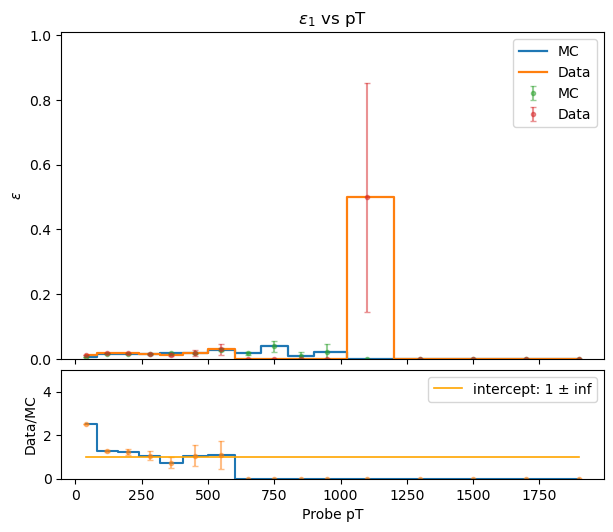

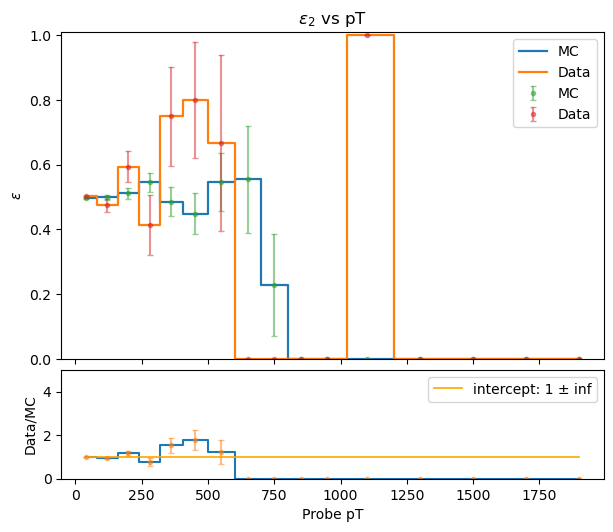

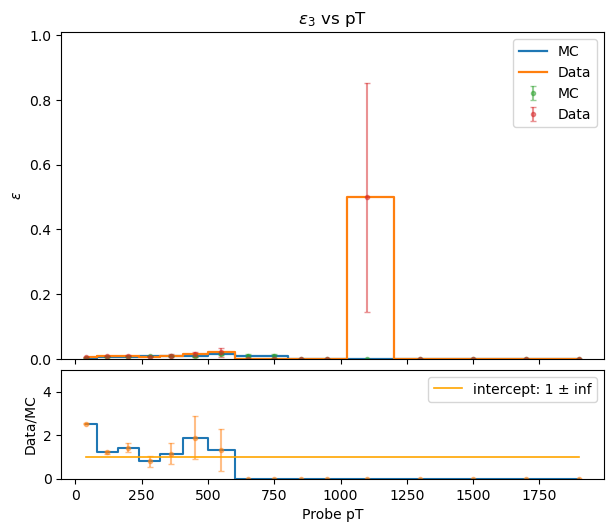

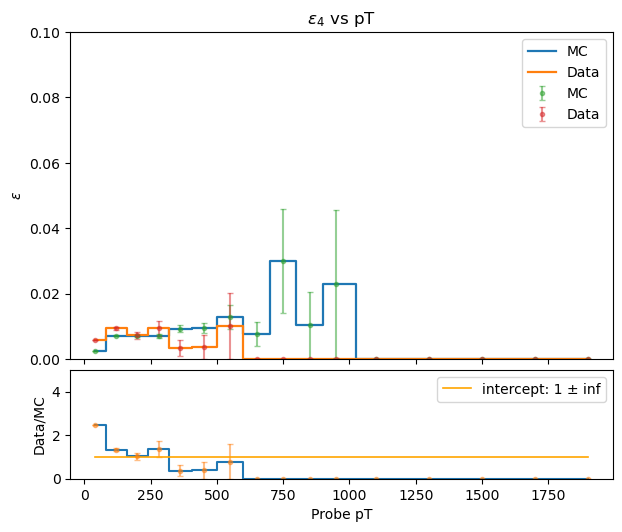

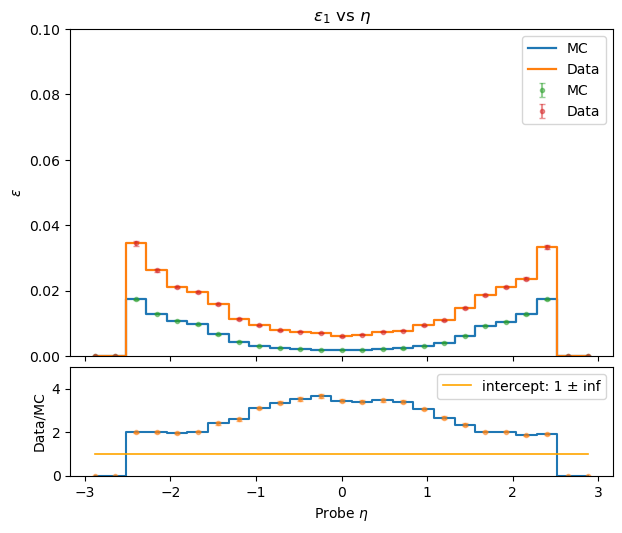

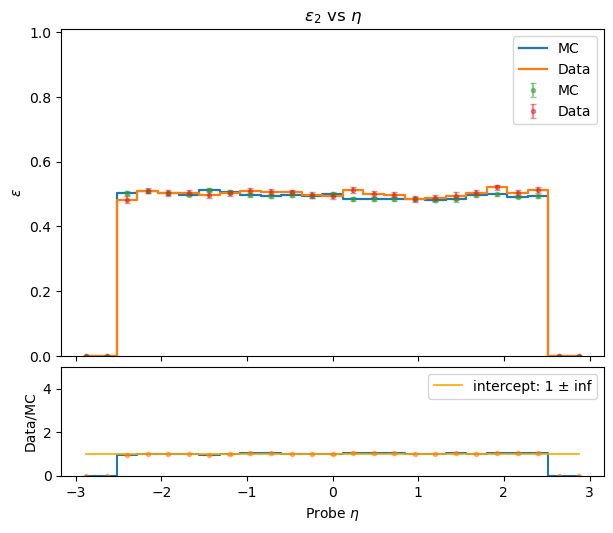

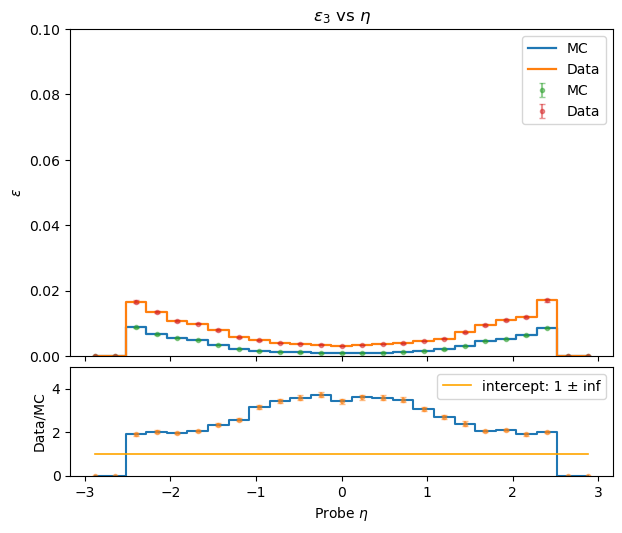

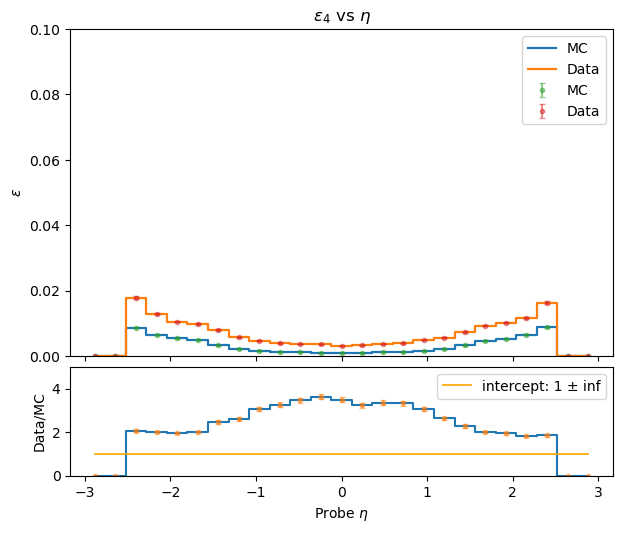

In [29]:
# no additional selection

    #ε1 = (pp + mm) / (pp + mm + pm)
    #ε2 =  pp / (pp + mm)
    #ε3 = pp  / (pp + mm + pm)
    #ε4 = mm  / (pp + mm + pm)

dt_eps1_pt_plus, dt_eps2_pt_plus, dt_eps3_pt_plus, dt_eps4_pt_plus = build_eps_hists(
    data_pairs, xaxis="probe_pt", probe_region=None, tag_charge=None, tag_ptbin=None, tag_region="barrel"   
)
mc_eps1_pt_plus, mc_eps2_pt_plus, mc_eps3_pt_plus, mc_eps4_pt_plus = build_eps_hists(
    mc_pairs, xaxis="probe_pt", probe_region=None, tag_charge=None, tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_pt_plus, mc_eps1_pt_plus,
    xlabel=r"Probe pT",
    title = r"$\epsilon_1$ vs pT",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_pt_plus, mc_eps2_pt_plus,
    xlabel=r"Probe pT",
    title=r"$\epsilon_2$ vs pT",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps3_pt_plus, mc_eps3_pt_plus,
    xlabel=r"Probe pT",
    title = r"$\epsilon_3$ vs pT",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_pt_plus, mc_eps4_pt_plus,
    xlabel=r"Probe pT",
    title=r"$\epsilon_4$ vs pT",
    do_fit=True,
    ylim = (0,0.1),
)



dt_eps1_eta_plus, dt_eps2_eta_plus, dt_eps3_eta_plus, dt_eps4_eta_plus = build_eps_hists(
    data_pairs, xaxis="probe_eta", probe_region=None, tag_charge=None, tag_ptbin=None, tag_region="barrel"
)
mc_eps1_eta_plus, mc_eps2_eta_plus, mc_eps3_eta_plus, mc_eps4_eta_plus = build_eps_hists(
    mc_pairs, xaxis="probe_eta", probe_region=None, tag_charge=None, tag_ptbin=None, tag_region="barrel"
)

plot_eps_data_mc_with_ratio(
    dt_eps1_eta_plus, mc_eps1_eta_plus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_1$ vs $\eta$",
    do_fit=True,
    ylim = (0,0.1),
)
plot_eps_data_mc_with_ratio(
    dt_eps2_eta_plus, mc_eps2_eta_plus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_2$ vs $\eta$",
    do_fit=True,
    ylim = (0,1.01),
)
plot_eps_data_mc_with_ratio(
    dt_eps3_eta_plus, mc_eps3_eta_plus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_3$ vs $\eta$",
    do_fit=True,
    ylim = (0,0.1),
)
plot_eps_data_mc_with_ratio(
    dt_eps4_eta_plus, mc_eps4_eta_plus,
    xlabel=r"Probe $\eta$",
    title=r"$\epsilon_4$ vs $\eta$",
    do_fit=True,
    ylim = (0,0.1),
)

